In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import pad
from safetensors.torch import load_file

In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# This is too big to put on GitHub, but I finetuned using the instructions in the DNABERT-2 repo
# You will need to run the run_dnabert2.sh script in ./disabled_head_evals/, then point to the model weights within output/dnabert2,
# or move + rename like I have to make it a bit cleaner:
# model_file_path = "./disabled_head_evals/output/DNABERT2_EMP_H3_model/model.safetensors"
model_file_path = "./attribution_guided_training/output/DNABERT2_AGT_EMP_H3/checkpoint-600/model.safetensors"
loaded_state_dict = load_file(model_file_path, device=device)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [6]:
from lrp_engine import LRPEngine, checkpoint_hook
from disabled_head_evals.disable_head import make_hook

In [7]:
# disable_layer_head_ind = (2,7)
model.bert.encoder.layer[0].attention.self.register_forward_hook(checkpoint_hook)
# for layer_ind, layer_module in enumerate(model.bert.encoder.layer):
    # layer_module.attention.self.register_forward_hook(checkpoint_hook)
    # if layer_ind == disable_layer_head_ind[0]:
    #     layer_module.attention.self.register_forward_hook(make_hook(disable_layer_head_ind[1]))

In [8]:
data_path = "../../external/GUE/EMP/H3/test.csv"
batch_size = 500
batch_start = 0
with open(data_path, "r") as fileIn:
    fileIn.readline()
    dna = []
    labels = []
    for _ in range(batch_start):
        fileIn.readline()
    for _ in range(batch_size):
        line = fileIn.readline()
        line, label = line.split(",")
        dna.append(line.strip())
        labels.append(int(label.strip()))

inputs = sorted([ tokenizer(x, return_tensors = 'pt')["input_ids"] for x in dna ], key=lambda t: t.shape[-1], reverse=True)


In [9]:
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_f

In [10]:
engine = LRPEngine()

In [11]:
for i in range(10):
    input_ids = tokenizer(dna[i], return_tensors="pt")["input_ids"]
    output = model(input_ids.to(device))
    logits = output[0]
    r = engine.run(logits)
    (r[0][0].sum() + r[1][0].sum() + r[1][1].sum()).backward()
    # torch.cuda.memory._dump_snapshot(f"snapshot{i}.pickle")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [17]:
import pickle
data = [ pickle.load(open(f"snapshot{i}.pickle", "rb")) for i in range(100) ]

In [18]:
mutex = []
all_segments = set()
for i in range(10):
    new_segments = []
    for seg in data[i]["segments"]:
        segid = (seg["address"], seg["total_size"])
        if segid not in all_segments:
            all_segments.add(segid)
            new_segments.append(segid)
    mutex.append(new_segments)
        
    

In [19]:
print([ len(s) for s in [ d["segments"] for d in data ]])
print([ len(m) for m in mutex ])

[233, 234, 234, 234, 234, 234, 235, 235, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]
[233, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
engine.promise_bucket.clear_all()

In [12]:
import gc
import torch

def list_live_tensors():
    return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]

In [13]:
len(list_live_tensors())

C:\Users\Kevin\AppData\Local\Temp\ipykernel_2080\2611729171.py:5: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


1106

In [14]:
tensors = list_live_tensors()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_16512\2611729171.py:5: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


In [22]:
for i, t in enumerate(list_live_tensors()):
    if str(t.device) == "cuda:0":
        print(i, type(t), t.grad_fn, t.size(), t.dtype, t.device, hex(id(t)))

0 <class 'torch.nn.parameter.Parameter'> None torch.Size([768]) torch.float32 cuda:0 0x11bb3820c50
1 <class 'torch.nn.parameter.Parameter'> None torch.Size([768, 768]) torch.float32 cuda:0 0x11bb3820bf0
2 <class 'torch.nn.parameter.Parameter'> None torch.Size([2]) torch.float32 cuda:0 0x11bb378c2f0
3 <class 'torch.nn.parameter.Parameter'> None torch.Size([2, 768]) torch.float32 cuda:0 0x11bb36ffdd0
4 <class 'torch.nn.parameter.Parameter'> None torch.Size([768]) torch.float32 cuda:0 0x11bb378fd10
5 <class 'torch.nn.parameter.Parameter'> None torch.Size([768]) torch.float32 cuda:0 0x11bb378c230
6 <class 'torch.nn.parameter.Parameter'> None torch.Size([2, 768]) torch.float32 cuda:0 0x11bb378f8f0
7 <class 'torch.nn.parameter.Parameter'> None torch.Size([4096, 768]) torch.float32 cuda:0 0x11bb381d3d0
8 <class 'torch.nn.parameter.Parameter'> None torch.Size([768]) torch.float32 cuda:0 0x11bb381ebd0
9 <class 'torch.nn.parameter.Parameter'> None torch.Size([768]) torch.float32 cuda:0 0x11bb378

C:\Users\Kevin\AppData\Local\Temp\ipykernel_1088\2611729171.py:5: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


C:\Users\Kevin\AppData\Local\Temp\ipykernel_1088\2611729171.py:5: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


176

In [11]:
outputs : torch.Tensor = model(inputs[0].to(device))

In [12]:
# Single example test
logits = outputs[0]
hidden_states = outputs.hidden_states
relevance_outputs = engine.run(hidden_states)


In [13]:
relevance_outputs[1][0]

tensor([[-2.1912e-02,  2.0309e-03,  3.9736e-03,  1.5134e-03,  9.0244e-04,
          9.5865e-04,  4.0233e-03,  1.4851e-03,  4.9424e-04,  2.5098e-03,
         -1.4884e-03, -3.1789e-04, -6.3683e-03,  1.4289e-03, -1.0814e-03,
         -2.7650e-02,  7.9039e-03, -1.0258e-04,  6.5849e-04,  4.1951e-03,
          2.1755e-03,  5.1061e-04, -3.6433e-04,  3.1956e-03,  1.5883e-02,
          2.0308e-03,  1.2539e-02,  3.5900e-04,  1.3374e-03,  1.2811e-03,
          5.1224e-03, -3.4543e-02, -1.2103e-03, -1.3955e-03, -7.2601e-03,
         -8.0210e-04, -6.9072e-03, -1.3471e-03, -6.2682e-03,  1.2709e-03,
          1.1202e-02, -5.7094e-03,  2.8581e-04,  7.2156e-03, -8.1140e-04,
          6.0013e-03,  3.6650e-03,  1.1304e-04, -1.0607e-04, -7.6525e-03,
          3.3969e-03,  5.6197e-03,  2.8242e-03,  2.6938e-03,  3.3450e-03,
          5.2840e-03,  1.1783e-03, -1.8079e-04,  2.3764e-03, -1.1778e-02,
         -1.0657e-03,  1.0139e-03,  1.1681e-03,  1.0986e-02,  2.2001e-03,
          2.2590e-02, -1.5050e-02,  1.

In [13]:
relevance_outputs1 = engine.run(hidden_states)

In [14]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(relevance_outputs[0] + relevance_outputs[1], relevance_outputs1[0] + relevance_outputs1[1])
]

[tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>)]

In [11]:
from util import accumulate_variable_matrix, visualize_attention_layer_relevance, LRPEmbeddingModelEval

In [25]:
# Most Relevant First (MoRF) perturbation evaluation
# Make a first pass to get the top 10 most relevant tokens from each input.
checkpoint_vals, param_vals, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, engine, dna, labels)
print(tpnfpn) # Order is true pos, true neg, false pos, false neg

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.08it/s]

(87, 91, 7, 15)


In [13]:
# Create the first mask
morf_mask_inds = [ [ 1 + p[:,1:-1].argmax(dim=-1).cpu() ] for p in param_vals ]
# Save the T/F P/N counts for plotting later
morf_tpnfpns = [tpnfpn]
lerf_tpnfpns = [tpnfpn]
# Max num of tokens to remove
toks_to_mask = 90

In [14]:
for i in range(toks_to_mask):
    # We will sequentially remove the top k tokens from each input and assess performance.
    _, param_vals1, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, run_lrp=False, masked_inds=morf_mask_inds)
    print(i, tpnfpn)
    morf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    morf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2).indices[0].cpu() for p in param_vals ]
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.08it/s]


(88, 93, 5, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.76it/s]


(88, 92, 6, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.54it/s]


(87, 92, 6, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.93it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.58it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.41it/s]


(86, 91, 7, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.64it/s]


(87, 90, 8, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.60it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.01it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.13it/s]


(84, 87, 11, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.07it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.82it/s]


(84, 91, 7, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.55it/s]


(84, 90, 8, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.01it/s]


(84, 90, 8, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.68it/s]


(82, 90, 8, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.54it/s]


(82, 90, 8, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.73it/s]


(82, 91, 7, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.51it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.77it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.25it/s]


(79, 91, 7, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.07it/s]


(78, 92, 6, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.06it/s]


(79, 92, 6, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.03it/s]


(79, 91, 7, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.73it/s]


(76, 91, 7, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.85it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.14it/s]


(76, 92, 6, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.19it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.57it/s]


(75, 89, 9, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.30it/s]


(72, 89, 9, 30)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.37it/s]


(73, 91, 7, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.96it/s]


(71, 90, 8, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.72it/s]


(69, 92, 6, 33)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.57it/s]


(67, 92, 6, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.15it/s]


(69, 90, 8, 33)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.80it/s]


(65, 92, 6, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.19it/s]


(59, 92, 6, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.07it/s]


(58, 90, 8, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.21it/s]


(59, 91, 7, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.64it/s]


(57, 92, 6, 45)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.50it/s]


(59, 92, 6, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.41it/s]


(59, 89, 9, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.61it/s]


(54, 93, 5, 48)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.12it/s]


(55, 92, 6, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.41it/s]


(50, 93, 5, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.85it/s]


(48, 94, 4, 54)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.73it/s]


(46, 95, 3, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.58it/s]


(46, 95, 3, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.79it/s]


(44, 93, 5, 58)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.87it/s]


(40, 93, 5, 62)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.73it/s]


(38, 93, 5, 64)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.50it/s]


(34, 94, 4, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.97it/s]


(34, 94, 4, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.22it/s]


(33, 96, 2, 69)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.30it/s]


(30, 96, 2, 72)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.18it/s]


(30, 97, 1, 72)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.53it/s]


(28, 97, 1, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.29it/s]


(28, 97, 1, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.87it/s]


(25, 97, 1, 77)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.40it/s]


(23, 97, 1, 79)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.76it/s]


(17, 97, 1, 85)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.25it/s]


(16, 97, 1, 86)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.68it/s]


(13, 97, 1, 89)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.81it/s]


(11, 96, 2, 91)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.30it/s]


(10, 96, 2, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.38it/s]


(9, 97, 1, 93)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.85it/s]


(9, 97, 1, 93)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.71it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.11it/s]


(3, 97, 1, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.40it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.38it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.33it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.14it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.89it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.05it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.10it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.95it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.71it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.40it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.53it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.57it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.40it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.15it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.73it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.81it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.12it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.64it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.21it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.49it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.29it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.77it/s]

(0, 98, 0, 102)


In [15]:
# Now we will do Least Relevant First (LeRF) perturbation
lerf_mask_inds = [ [ 1 + p[:,1:-1].argmin(dim=-1).cpu() ] for p in param_vals ]

In [16]:
for i in range(toks_to_mask):
    # We will sequentially remove the bottom k tokens from each input and assess performance.
    _, param_vals1, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, masked_inds=lerf_mask_inds, run_lrp=False)
    print(i, tpnfpn)
    lerf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    lerf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2, largest=False).indices[0].cpu() for p in param_vals ]
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.26it/s]


(89, 93, 5, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.16it/s]


(90, 93, 5, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.03it/s]


(88, 94, 4, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.51it/s]


(91, 94, 4, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.14it/s]


(91, 93, 5, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.10it/s]


(89, 92, 6, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.27it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.13it/s]


(86, 92, 6, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.43it/s]


(87, 93, 5, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.47it/s]


(86, 92, 6, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.60it/s]


(86, 93, 5, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.81it/s]


(85, 92, 6, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.97it/s]


(85, 92, 6, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.79it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.43it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.78it/s]


(82, 91, 7, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.54it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.49it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.28it/s]


(83, 90, 8, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.58it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.90it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.19it/s]


(82, 89, 9, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.03it/s]


(81, 89, 9, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.06it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.33it/s]


(81, 90, 8, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.72it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.87it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.79it/s]


(80, 89, 9, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.01it/s]


(80, 90, 8, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.22it/s]


(77, 88, 10, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.66it/s]


(75, 89, 9, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.14it/s]


(76, 89, 9, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.93it/s]


(76, 88, 10, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.09it/s]


(73, 88, 10, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.34it/s]


(74, 89, 9, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.56it/s]


(71, 88, 10, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.64it/s]


(71, 89, 9, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.81it/s]


(74, 89, 9, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.81it/s]


(75, 90, 8, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.68it/s]


(74, 90, 8, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.29it/s]


(73, 91, 7, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.77it/s]


(70, 91, 7, 32)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.73it/s]


(71, 90, 8, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.12it/s]


(67, 91, 7, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.66it/s]


(71, 92, 6, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.10it/s]


(66, 93, 5, 36)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.99it/s]


(65, 94, 4, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.65it/s]


(64, 94, 4, 38)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.17it/s]


(62, 95, 3, 40)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.81it/s]


(56, 94, 4, 46)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.28it/s]


(55, 93, 5, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.67it/s]


(54, 93, 5, 48)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.58it/s]


(52, 94, 4, 50)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.24it/s]


(50, 94, 4, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.50it/s]


(50, 94, 4, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.77it/s]


(48, 96, 2, 54)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.18it/s]


(44, 96, 2, 58)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.26it/s]


(42, 96, 2, 60)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.07it/s]


(41, 96, 2, 61)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.84it/s]


(36, 97, 1, 66)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.39it/s]


(34, 97, 1, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.03it/s]


(33, 97, 1, 69)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.19it/s]


(26, 97, 1, 76)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.33it/s]


(24, 97, 1, 78)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.60it/s]


(20, 97, 1, 82)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.30it/s]


(18, 97, 1, 84)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.52it/s]


(17, 97, 1, 85)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.54it/s]


(14, 97, 1, 88)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.47it/s]


(10, 97, 1, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.11it/s]


(6, 98, 0, 96)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.34it/s]


(6, 98, 0, 96)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.46it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.22it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.06it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.03it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.37it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.42it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.36it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.25it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.73it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.89it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.07it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.70it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.07it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.92it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.43it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.17it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.05it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.65it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.87it/s]

(0, 98, 0, 102)


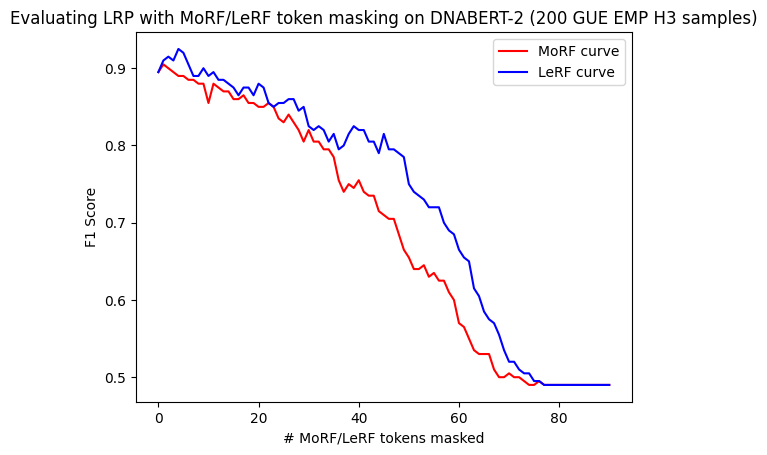

In [17]:
from matplotlib import pyplot as plt

# Y axis will be F1 scores of each trial
x_axis = list(range(toks_to_mask + 1))
# y_axis_morf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in morf_tpnfpns ]
# y_axis_lerf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in lerf_tpnfpns ]
y_axis_morf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in morf_tpnfpns ]
y_axis_lerf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in lerf_tpnfpns ]

plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")

plt.xlabel("# MoRF/LeRF tokens masked")
plt.ylabel("F1 Score")
plt.title("Evaluating LRP with MoRF/LeRF token masking on DNABERT-2 (200 GUE EMP H3 samples)")
plt.legend(["MoRF curve", "LeRF curve"])

# Display the plot
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.88it/s]


(88, 93, 5, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.36it/s]


(87, 92, 6, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.96it/s]


(87, 92, 6, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.24it/s]


(89, 92, 6, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.17it/s]


(89, 92, 6, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.03it/s]


(91, 92, 6, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.32it/s]


(91, 91, 7, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.84it/s]


(91, 91, 7, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.99it/s]


(89, 90, 8, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.82it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.20it/s]


(86, 91, 7, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.83it/s]


(85, 90, 8, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.74it/s]


(86, 91, 7, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.56it/s]


(85, 90, 8, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.42it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.16it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.51it/s]


(85, 92, 6, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.84it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.25it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.24it/s]


(82, 88, 10, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.26it/s]


(81, 88, 10, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.30it/s]


(81, 92, 6, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.87it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.92it/s]


(81, 92, 6, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.82it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.40it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.96it/s]


(80, 92, 6, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.04it/s]


(77, 92, 6, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.68it/s]


(76, 93, 5, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.86it/s]


(77, 92, 6, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.57it/s]


(77, 92, 6, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.08it/s]


(76, 92, 6, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.99it/s]


(75, 94, 4, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.61it/s]


(75, 92, 6, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.38it/s]


(71, 91, 7, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.17it/s]


(71, 91, 7, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.93it/s]


(72, 91, 7, 30)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.38it/s]


(71, 91, 7, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.86it/s]


(72, 91, 7, 30)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.79it/s]


(70, 91, 7, 32)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.19it/s]


(70, 91, 7, 32)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.81it/s]


(67, 91, 7, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.65it/s]


(63, 92, 6, 39)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.84it/s]


(63, 92, 6, 39)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.24it/s]


(62, 93, 5, 40)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.25it/s]


(61, 95, 3, 41)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.39it/s]


(63, 95, 3, 39)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.73it/s]


(62, 95, 3, 40)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.33it/s]


(61, 94, 4, 41)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.90it/s]


(55, 95, 3, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.32it/s]


(53, 95, 3, 49)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.10it/s]


(55, 96, 2, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.28it/s]


(51, 96, 2, 51)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.00it/s]


(46, 96, 2, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.12it/s]


(44, 97, 1, 58)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.68it/s]


(43, 97, 1, 59)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.15it/s]


(43, 97, 1, 59)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.02it/s]


(37, 97, 1, 65)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.33it/s]


(34, 97, 1, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.63it/s]


(29, 97, 1, 73)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.24it/s]


(28, 97, 1, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.16it/s]


(26, 97, 1, 76)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.51it/s]


(24, 97, 1, 78)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.94it/s]


(23, 97, 1, 79)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.50it/s]


(20, 97, 1, 82)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.40it/s]


(18, 97, 1, 84)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.83it/s]


(15, 97, 1, 87)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.62it/s]


(10, 97, 1, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.44it/s]


(8, 98, 0, 94)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.72it/s]


(6, 98, 0, 96)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.62it/s]


(5, 98, 0, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.45it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.41it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.30it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.06it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.90it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.10it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.11it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.58it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.99it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.24it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.76it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.38it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.88it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.45it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.88it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.23it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.42it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.49it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.96it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.74it/s]


(86, 92, 6, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.67it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.02it/s]


(86, 90, 8, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.00it/s]


(88, 88, 10, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.49it/s]


(87, 89, 9, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.00it/s]


(90, 89, 9, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.88it/s]


(90, 87, 11, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.46it/s]


(90, 88, 10, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.05it/s]


(87, 88, 10, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.26it/s]


(86, 89, 9, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.30it/s]


(86, 88, 10, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.74it/s]


(87, 88, 10, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.50it/s]


(89, 87, 11, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.61it/s]


(87, 89, 9, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.95it/s]


(88, 89, 9, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.20it/s]


(89, 89, 9, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.18it/s]


(90, 89, 9, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.16it/s]


(89, 88, 10, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.19it/s]


(89, 88, 10, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.31it/s]


(86, 87, 11, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.66it/s]


(84, 89, 9, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.56it/s]


(83, 88, 10, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.23it/s]


(80, 89, 9, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.24it/s]


(78, 90, 8, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.48it/s]


(75, 92, 6, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.19it/s]


(76, 91, 7, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.81it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.38it/s]


(76, 93, 5, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.01it/s]


(76, 92, 6, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.63it/s]


(75, 92, 6, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.76it/s]


(73, 92, 6, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.97it/s]


(75, 93, 5, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.89it/s]


(75, 92, 6, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.59it/s]


(75, 93, 5, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.55it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.86it/s]


(73, 91, 7, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.18it/s]


(71, 92, 6, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.61it/s]


(73, 92, 6, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.26it/s]


(71, 91, 7, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.75it/s]


(71, 92, 6, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.02it/s]


(71, 92, 6, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.93it/s]


(65, 93, 5, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.27it/s]


(65, 92, 6, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.66it/s]


(63, 92, 6, 39)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.39it/s]


(58, 93, 5, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.32it/s]


(58, 94, 4, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.23it/s]


(58, 92, 6, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.04it/s]


(58, 92, 6, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.13it/s]


(55, 94, 4, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.93it/s]


(55, 94, 4, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.63it/s]


(51, 95, 3, 51)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.68it/s]


(46, 95, 3, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.83it/s]


(47, 95, 3, 55)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.58it/s]


(45, 95, 3, 57)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.58it/s]


(41, 95, 3, 61)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.40it/s]


(38, 95, 3, 64)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.10it/s]


(37, 95, 3, 65)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.23it/s]


(32, 95, 3, 70)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.37it/s]


(30, 93, 5, 72)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.86it/s]


(27, 95, 3, 75)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.49it/s]


(26, 95, 3, 76)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.89it/s]


(21, 95, 3, 81)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.59it/s]


(20, 95, 3, 82)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.69it/s]


(17, 96, 2, 85)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.81it/s]


(12, 97, 1, 90)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.10it/s]


(10, 96, 2, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.11it/s]


(8, 96, 2, 94)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.38it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.33it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.81it/s]


(4, 97, 1, 98)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.69it/s]


(3, 97, 1, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.50it/s]


(2, 97, 1, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.49it/s]


(1, 97, 1, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.71it/s]


(1, 97, 1, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.21it/s]


(1, 97, 1, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.73it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.25it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.61it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.61it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.75it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.50it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.25it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.71it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.68it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.67it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.47it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.99it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.60it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.26it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.75it/s]


(0, 98, 0, 102)


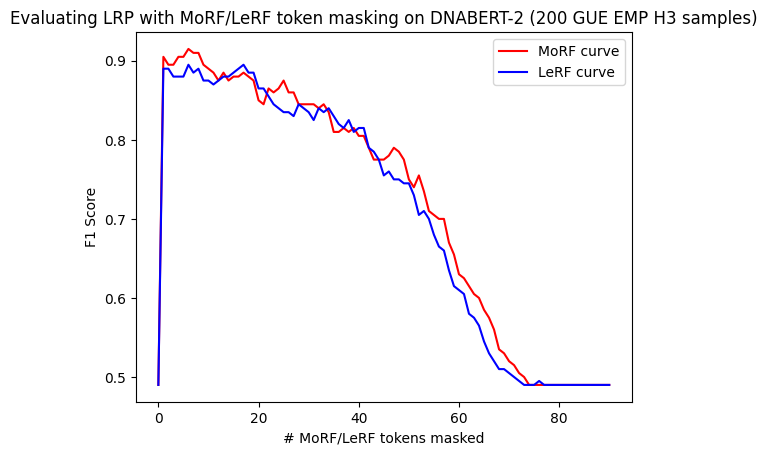

In [22]:
attrs = [ torch.rand_like(p) for p in param_vals ]
# Create the first mask
morf_mask_inds = [ [ 1 + p[:,1:-1].argmax(dim=-1).cpu() ] for p in attrs ]
# Save the T/F P/N counts for plotting later
morf_tpnfpns = [tpnfpn]
lerf_tpnfpns = [tpnfpn]

for i in range(toks_to_mask):
    # We will sequentially remove the top k tokens from each input and assess performance.
    _, _, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, run_lrp=False, masked_inds=morf_mask_inds)
    print(tpnfpn)
    morf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    morf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2).indices[0].cpu() for p in attrs ]

# Now we will do Least Relevant First (LeRF) perturbation
lerf_mask_inds = [ [ 1 + p[:,1:-1].argmin(dim=-1).cpu() ] for p in attrs ]

for i in range(toks_to_mask):
    # We will sequentially remove the bottom k tokens from each input and assess performance.
    _, _, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, masked_inds=lerf_mask_inds, run_lrp=False)
    print(tpnfpn)
    lerf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    lerf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2, largest=False).indices[0].cpu() for p in attrs ]


from matplotlib import pyplot as plt

# Y axis will be F1 scores of each trial
x_axis = list(range(toks_to_mask + 1))
# y_axis_morf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in morf_tpnfpns ]
# y_axis_lerf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in lerf_tpnfpns ]
y_axis_morf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in morf_tpnfpns ]
y_axis_lerf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in lerf_tpnfpns ]

plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")

plt.xlabel("# MoRF/LeRF tokens masked")
plt.ylabel("F1 Score")
plt.title("Evaluating LRP with MoRF/LeRF token masking on DNABERT-2 (200 GUE EMP H3 samples)")
plt.legend(["MoRF curve", "LeRF curve"])

# Display the plot
plt.show()

In [20]:
engine.use_attn_lrp = False

In [21]:
_, no_attn_lrp_attrs, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, engine, dna, labels)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.83it/s]


In [ ]:
# attrs = torch.load("../../../dynasliceBERT/dnabert2_captum.pt")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.34it/s]


(88, 93, 5, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.19it/s]


(88, 92, 6, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.71it/s]


(87, 92, 6, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.42it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.68it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.38it/s]


(86, 91, 7, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.60it/s]


(87, 90, 8, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.38it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.87it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.99it/s]


(84, 87, 11, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.56it/s]


(85, 91, 7, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.36it/s]


(84, 91, 7, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.06it/s]


(84, 90, 8, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.80it/s]


(84, 90, 8, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.73it/s]


(82, 90, 8, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.32it/s]


(82, 90, 8, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.49it/s]


(82, 91, 7, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.66it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.93it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.54it/s]


(79, 91, 7, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.64it/s]


(78, 92, 6, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.89it/s]


(79, 92, 6, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.66it/s]


(79, 91, 7, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.13it/s]


(76, 91, 7, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.48it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.48it/s]


(76, 92, 6, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.01it/s]


(75, 91, 7, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.68it/s]


(75, 89, 9, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.91it/s]


(72, 89, 9, 30)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.49it/s]


(73, 91, 7, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.37it/s]


(71, 90, 8, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.60it/s]


(69, 92, 6, 33)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.02it/s]


(67, 92, 6, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.26it/s]


(69, 90, 8, 33)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.35it/s]


(65, 92, 6, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.91it/s]


(59, 92, 6, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.99it/s]


(58, 90, 8, 44)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.95it/s]


(59, 91, 7, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.83it/s]


(57, 92, 6, 45)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.60it/s]


(59, 92, 6, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.44it/s]


(59, 89, 9, 43)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.16it/s]


(54, 93, 5, 48)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.29it/s]


(55, 92, 6, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.32it/s]


(50, 93, 5, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.25it/s]


(48, 94, 4, 54)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.72it/s]


(46, 95, 3, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.28it/s]


(46, 95, 3, 56)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.90it/s]


(44, 93, 5, 58)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.29it/s]


(40, 93, 5, 62)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.26it/s]


(38, 93, 5, 64)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.80it/s]


(34, 94, 4, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.25it/s]


(34, 94, 4, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.92it/s]


(33, 96, 2, 69)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.97it/s]


(30, 96, 2, 72)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.41it/s]


(30, 97, 1, 72)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.93it/s]


(28, 97, 1, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.28it/s]


(28, 97, 1, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.25it/s]


(25, 97, 1, 77)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.12it/s]


(23, 97, 1, 79)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.16it/s]


(17, 97, 1, 85)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.57it/s]


(16, 97, 1, 86)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.83it/s]


(13, 97, 1, 89)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.65it/s]


(11, 96, 2, 91)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.61it/s]


(10, 96, 2, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.57it/s]


(9, 97, 1, 93)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.37it/s]


(9, 97, 1, 93)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.22it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.95it/s]


(3, 97, 1, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.50it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.62it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.92it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.61it/s]


(2, 98, 0, 100)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.37it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.46it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.21it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.46it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.54it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.65it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.89it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.95it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.04it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.04it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.09it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.22it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.89it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.70it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.81it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.05it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.87it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.37it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.50it/s]


(89, 93, 5, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.48it/s]


(90, 93, 5, 12)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.22it/s]


(88, 94, 4, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.78it/s]


(91, 94, 4, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.70it/s]


(91, 93, 5, 11)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.24it/s]


(89, 92, 6, 13)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.57it/s]


(87, 91, 7, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.35it/s]


(86, 92, 6, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.10it/s]


(87, 93, 5, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.24it/s]


(86, 92, 6, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.54it/s]


(86, 93, 5, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.15it/s]


(85, 92, 6, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.56it/s]


(85, 92, 6, 17)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.02it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.66it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.79it/s]


(82, 91, 7, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.57it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.46it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.24it/s]


(83, 90, 8, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.75it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.85it/s]


(83, 92, 6, 19)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.14it/s]


(82, 89, 9, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.68it/s]


(81, 89, 9, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.81it/s]


(80, 91, 7, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.89it/s]


(81, 90, 8, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.59it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.22it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.61it/s]


(80, 89, 9, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.49it/s]


(80, 90, 8, 22)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.25it/s]


(77, 88, 10, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.95it/s]


(75, 89, 9, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.14it/s]


(76, 89, 9, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.69it/s]


(76, 88, 10, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.22it/s]


(73, 88, 10, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.47it/s]


(74, 89, 9, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.57it/s]


(71, 88, 10, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.79it/s]


(71, 89, 9, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.61it/s]


(74, 89, 9, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.18it/s]


(75, 90, 8, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.18it/s]


(74, 90, 8, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.64it/s]


(73, 91, 7, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.22it/s]


(70, 91, 7, 32)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.61it/s]


(71, 90, 8, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.29it/s]


(67, 91, 7, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.18it/s]


(71, 92, 6, 31)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.28it/s]


(66, 93, 5, 36)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.39it/s]


(65, 94, 4, 37)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.00it/s]


(64, 94, 4, 38)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.69it/s]


(62, 95, 3, 40)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.80it/s]


(56, 94, 4, 46)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.19it/s]


(55, 93, 5, 47)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.85it/s]


(54, 93, 5, 48)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.17it/s]


(52, 94, 4, 50)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.32it/s]


(50, 94, 4, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.20it/s]


(50, 94, 4, 52)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.05it/s]


(48, 96, 2, 54)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.55it/s]


(44, 96, 2, 58)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.67it/s]


(42, 96, 2, 60)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.80it/s]


(41, 96, 2, 61)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.64it/s]


(36, 97, 1, 66)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.00it/s]


(34, 97, 1, 68)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.97it/s]


(33, 97, 1, 69)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.14it/s]


(26, 97, 1, 76)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.87it/s]


(24, 97, 1, 78)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.00it/s]


(20, 97, 1, 82)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.36it/s]


(18, 97, 1, 84)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.49it/s]


(17, 97, 1, 85)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.07it/s]


(14, 97, 1, 88)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.67it/s]


(10, 97, 1, 92)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.22it/s]


(6, 98, 0, 96)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.58it/s]


(6, 98, 0, 96)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.28it/s]


(5, 97, 1, 97)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.03it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.97it/s]


(3, 98, 0, 99)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.65it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.26it/s]


(1, 98, 0, 101)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.99it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.11it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.15it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.40it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.10it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.24it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.68it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.97it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.20it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.33it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.94it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.32it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.97it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.63it/s]


(0, 98, 0, 102)


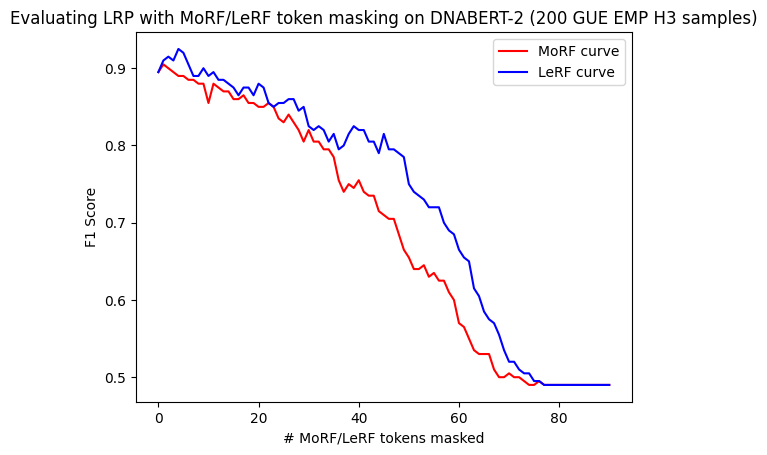

In [22]:
attrs = no_attn_lrp_attrs
# Create the first mask
morf_mask_inds = [ [ 1 + p[:,1:-1].argmax(dim=-1).cpu() ] for p in attrs ]
# Save the T/F P/N counts for plotting later
morf_tpnfpns = [tpnfpn]
lerf_tpnfpns = [tpnfpn]

for i in range(toks_to_mask):
    # We will sequentially remove the top k tokens from each input and assess performance.
    _, _, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, run_lrp=False, masked_inds=morf_mask_inds)
    print(tpnfpn)
    morf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    morf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2).indices[0].cpu() for p in attrs ]

# Now we will do Least Relevant First (LeRF) perturbation
lerf_mask_inds = [ [ 1 + p[:,1:-1].argmin(dim=-1).cpu() ] for p in attrs ]

for i in range(toks_to_mask):
    # We will sequentially remove the bottom k tokens from each input and assess performance.
    _, _, tpnfpn = LRPEmbeddingModelEval(model, tokenizer, None, dna, labels, masked_inds=lerf_mask_inds, run_lrp=False)
    print(tpnfpn)
    lerf_tpnfpns.append(tpnfpn)

    # Update the mask with a new topk including the next most relevant token from the original attribution.
    lerf_mask_inds = [ 1 + p[:,1:-1].topk(i + 2, largest=False).indices[0].cpu() for p in attrs ]


from matplotlib import pyplot as plt

# Y axis will be F1 scores of each trial
x_axis = list(range(toks_to_mask + 1))
# y_axis_morf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in morf_tpnfpns ]
# y_axis_lerf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in lerf_tpnfpns ]
y_axis_morf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in morf_tpnfpns ]
y_axis_lerf = [ (entry[1] + entry[0]) / (sum(entry)) for entry in lerf_tpnfpns ]

plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")

plt.xlabel("# MoRF/LeRF tokens masked")
plt.ylabel("F1 Score")
plt.title("Evaluating LRP with MoRF/LeRF token masking on DNABERT-2 (200 GUE EMP H3 samples)")
plt.legend(["MoRF curve", "LeRF curve"])

# Display the plot
plt.show()

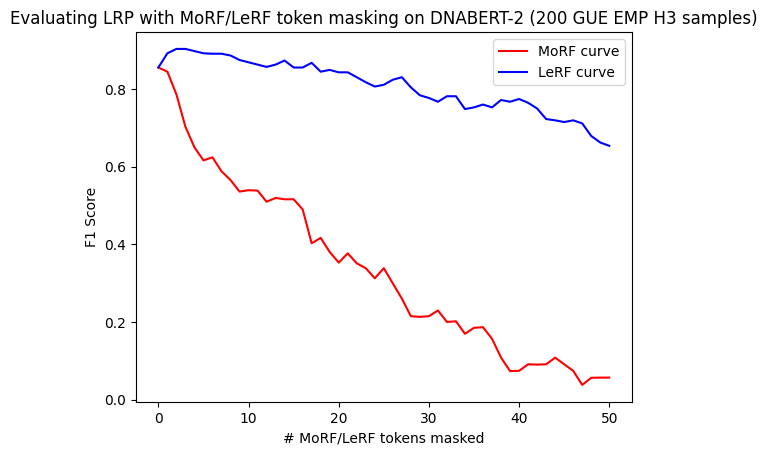

In [59]:
from matplotlib import pyplot as plt

# Y axis will be F1 scores of each trial
x_axis = list(range(toks_to_mask + 1))
y_axis_morf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in morf_tpnfpns ]
y_axis_lerf = [ (2 * entry[0]) / (2 * entry[0] + entry[2] + entry[3]) for entry in lerf_tpnfpns ]

plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")

plt.xlabel("# MoRF/LeRF tokens masked")
plt.ylabel("F1 Score")
plt.title("Evaluating LRP with MoRF/LeRF token masking on DNABERT-2 (200 GUE EMP H3 samples)")
plt.legend(["MoRF curve", "LeRF curve"])

# Display the plot
plt.show()

In [18]:
from sklearn.metrics import auc
import numpy as np

abc = auc(x_axis, y_axis_lerf) - auc(x_axis, y_axis_morf)
comprehensiveness = auc(x_axis, np.ones_like(y_axis_morf) * y_axis_morf[0]) - auc(x_axis, y_axis_morf)
sufficiency = auc(x_axis, np.ones_like(y_axis_lerf) * y_axis_lerf[0]) - auc(x_axis, y_axis_lerf)

In [19]:
print(abc, comprehensiveness, sufficiency)

3.3899999999999935 18.422499999999964 15.03249999999997


In [12]:
for i in range(50):
    engine = LRPEngine()
    checkpoint_vals, tpnfpn = LRPEval(model, engine)
    print(tpnfpn)
    checkpoint_vals = torch.stack(checkpoint_vals)
    head_relevances = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)(checkpoint_vals).sum(dim=1)
    head_flat_ind = head_relevances.abs().flatten()[:6*12].argmax()
    layer_ind = head_flat_ind // 12
    head_ind = head_flat_ind % 12
    print(f"disabling layer {layer_ind} head {head_ind}...")
    model.bert.encoder.layer[layer_ind].attention.self.register_forward_hook(make_hook(head_ind))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.65it/s]


(87, 92, 6, 15)
disabling layer 4 head 6...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.89it/s]


(99, 74, 24, 3)
disabling layer 0 head 4...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.92it/s]


(96, 83, 15, 6)
disabling layer 5 head 3...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.83it/s]


(95, 84, 14, 7)
disabling layer 0 head 8...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.80it/s]


(0, 98, 0, 102)
disabling layer 5 head 8...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.59it/s]


(0, 98, 0, 102)
disabling layer 5 head 1...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.51it/s]


(0, 98, 0, 102)
disabling layer 4 head 10...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.82it/s]


(0, 98, 0, 102)
disabling layer 3 head 8...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.91it/s]


(0, 98, 0, 102)
disabling layer 3 head 6...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.25it/s]


(0, 98, 0, 102)
disabling layer 4 head 8...


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:11<00:05, 11.46it/s]


KeyboardInterrupt: 

In [21]:
checkpoint_vals = torch.stack(checkpoint_vals)

In [22]:
head_relevances = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)(checkpoint_vals).sum(dim=1)

In [63]:
head_relevances

tensor([[-3.4294e-01,  6.3057e-01,  3.6247e+00,  1.1582e+01,  8.4226e+00,
         -3.7212e-01, -8.1762e-02, -3.3445e+00,  3.6190e+01, -2.4663e+00,
         -3.6092e+00, -1.3078e+00],
        [ 8.5120e-01, -1.0998e+00,  1.0758e+00, -2.6793e+00, -1.8625e+00,
         -3.1124e-01,  5.7460e-01, -3.0767e-01,  4.7241e+00, -2.2546e+00,
          1.8227e+00, -1.1367e+00],
        [ 2.3418e+01, -8.7768e-01,  4.3380e+00, -8.9683e-01,  1.3287e+01,
         -1.9282e+00,  7.3441e+00,  1.5501e+00,  1.0070e+00,  1.1257e+01,
         -3.5531e+00, -2.8559e+00],
        [ 6.6651e-01,  7.1176e+00,  3.2072e+00,  5.0402e+00,  5.2705e+00,
          2.0715e+00,  2.5219e+01, -4.2571e+00, -4.1667e+00, -8.3703e-01,
          8.2887e+00,  3.2810e+00],
        [ 8.2661e-01, -4.2652e-01,  8.1737e-01, -2.2299e+00, -1.9811e+01,
          1.9087e+00,  9.1616e+01, -6.6239e+00, -2.0667e-01,  2.3549e-01,
         -2.0250e+00, -1.2848e+00],
        [-4.4916e+00, -1.0863e+01, -7.7544e-01,  1.4581e+01,  1.0815e+01,
      

In [23]:
head_rel_rank = head_relevances.abs().flatten().topk(50).indices

In [70]:
head_rel_rank

torch.return_types.topk(
values=tensor([221.7307, 196.6200, 178.0266, 161.3895, 137.9336, 111.2018,  94.7053,
         91.6165,  77.1094,  74.8209,  73.8817,  65.4829,  62.6493,  57.2403,
         54.8580,  51.9706,  51.9661,  47.9503,  47.2470,  46.3645,  46.1325,
         37.0440,  36.1895,  34.4851,  34.0659,  33.0826,  32.6749,  29.8049,
         29.0327,  25.5031,  25.3010,  25.2195,  24.8075,  24.4873,  23.4175,
         22.2914,  22.1989,  21.5944,  19.8110,  19.1537,  19.0911,  18.6910,
         17.7353,  15.9269,  14.7719,  14.6994,  14.5813,  14.1494,  13.3887,
         13.2869], device='cuda:0'),
indices=tensor([115, 136, 137, 131, 138, 132, 139,  54, 134, 112, 141, 126, 128, 120,
         88, 140, 142,  90, 129, 122, 124, 123,   8, 114,  92, 117, 127, 125,
        116, 113,  95,  42, 110, 133,  24,  93,  68,  79,  52,  71, 105, 118,
        104, 121,  96, 106,  63, 108,  80,  28], device='cuda:0'))

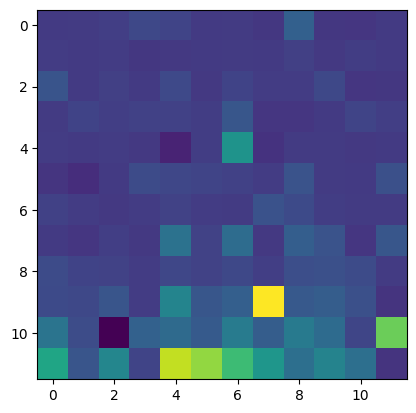

In [56]:
from matplotlib import pyplot as plt

plt.imshow(head_relevances.cpu())

In [31]:
# Begin removal of most relevant features and re-eval
for head_flat_ind in head_rel_rank.indices:
    layer_ind = head_flat_ind // 12
    head_ind = head_flat_ind % 12
    model.bert.encoder.layer[layer_ind].attention.self.register_forward_hook(make_hook(head_ind))
    _, res = LRPEval(model, engine, run_lrp=False)
    print(res)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.43it/s]


(87, 92, 6, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.98it/s]


(88, 92, 6, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.94it/s]


(88, 92, 6, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.19it/s]


(88, 92, 6, 14)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.09it/s]


(84, 92, 6, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.79it/s]


(84, 93, 5, 18)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.93it/s]


(67, 96, 2, 35)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.56it/s]


(81, 91, 7, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.06it/s]


(77, 93, 5, 25)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.48it/s]


(73, 94, 4, 29)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.34it/s]


(74, 93, 5, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.51it/s]


(70, 96, 2, 32)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.52it/s]


(76, 93, 5, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.45it/s]


(79, 92, 6, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.15it/s]


(79, 92, 6, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.85it/s]


(78, 92, 6, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.77it/s]


(78, 93, 5, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.85it/s]


(75, 95, 3, 27)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.69it/s]


(81, 92, 6, 21)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.84it/s]


(76, 93, 5, 26)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.98it/s]


(79, 92, 6, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.62it/s]


(74, 94, 4, 28)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.64it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.05it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.23it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.93it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.73it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.92it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.84it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.96it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.49it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 66.37it/s]


(0, 98, 0, 102)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.81it/s]


(0, 98, 0, 102)


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:03<00:00, 63.62it/s]


KeyboardInterrupt: 

In [22]:
neuron_attrs1.std()

tensor(0.5069, device='cuda:0')

In [23]:
neuron_attrs.std()

tensor(0.4396, device='cuda:0')

In [28]:
neuron_attrs1 = checkpoint_vals1[0].abs().sum(dim=0)
neuron_attrs1[512:577]

tensor([1.2692, 0.1881, 0.3524, 0.2307, 0.4984, 0.2258, 0.5840, 0.5363, 0.7132,
        0.1637, 0.7230, 2.5873, 0.4183, 0.2584, 0.1054, 0.3657, 0.4979, 1.3458,
        0.0720, 0.0797, 0.0613, 0.3524, 1.5790, 0.9091, 1.5605, 0.1478, 1.2354,
        0.1190, 0.2628, 0.2378, 0.1690, 0.0409, 0.0489, 0.0461, 0.7229, 0.5330,
        0.7235, 0.2306, 0.6707, 0.1812, 0.1870, 0.5901, 0.7388, 0.6782, 0.5185,
        0.9892, 0.8306, 0.1572, 1.4845, 0.4771, 0.3772, 0.2998, 0.7811, 0.0695,
        0.4814, 1.1995, 0.3941, 0.3433, 2.0442, 0.4991, 0.3498, 0.1804, 0.0838,
        0.2508, 0.0031], device='cuda:0')

In [29]:
neuron_attrs = checkpoint_vals[0].abs().sum(dim=0)
neuron_attrs[512:577]

tensor([1.1389, 0.1316, 0.3138, 0.1507, 0.4124, 0.1818, 0.5242, 0.4534, 0.6507,
        0.1495, 0.6932, 2.1092, 0.3687, 0.2389, 0.0709, 0.3310, 0.4779, 1.2615,
        0.0659, 0.0633, 0.0514, 0.3161, 1.4630, 0.8546, 1.2949, 0.1164, 1.1631,
        0.0820, 0.2505, 0.2280, 0.1448, 0.0320, 0.0281, 0.0455, 0.6423, 0.5210,
        0.6179, 0.2152, 0.5316, 0.1719, 0.1806, 0.5567, 0.6886, 0.5732, 0.4693,
        0.9478, 0.7871, 0.1408, 1.3133, 0.3558, 0.3600, 0.2408, 0.6618, 0.0441,
        0.4013, 1.2163, 0.3230, 0.2934, 1.9152, 0.4521, 0.2186, 0.1503, 0.0720,
        0.2186, 0.0029], device='cuda:0')

In [30]:
neuron_attrs1[512:577] - neuron_attrs[512:577]

tensor([ 1.3037e-01,  5.6507e-02,  3.8586e-02,  7.9987e-02,  8.5941e-02,
         4.3904e-02,  5.9856e-02,  8.2926e-02,  6.2458e-02,  1.4196e-02,
         2.9760e-02,  4.7810e-01,  4.9570e-02,  1.9486e-02,  3.4495e-02,
         3.4725e-02,  1.9938e-02,  8.4228e-02,  6.1334e-03,  1.6351e-02,
         9.9240e-03,  3.6254e-02,  1.1601e-01,  5.4463e-02,  2.6566e-01,
         3.1350e-02,  7.2278e-02,  3.6997e-02,  1.2276e-02,  9.8345e-03,
         2.4178e-02,  8.8188e-03,  2.0819e-02,  5.4446e-04,  8.0601e-02,
         1.1963e-02,  1.0560e-01,  1.5374e-02,  1.3917e-01,  9.2482e-03,
         6.4577e-03,  3.3320e-02,  5.0171e-02,  1.0502e-01,  4.9121e-02,
         4.1476e-02,  4.3425e-02,  1.6416e-02,  1.7124e-01,  1.2135e-01,
         1.7177e-02,  5.9008e-02,  1.1931e-01,  2.5448e-02,  8.0100e-02,
        -1.6781e-02,  7.1073e-02,  4.9932e-02,  1.2896e-01,  4.6933e-02,
         1.3121e-01,  3.0028e-02,  1.1863e-02,  3.2245e-02,  2.0363e-04],
       device='cuda:0')

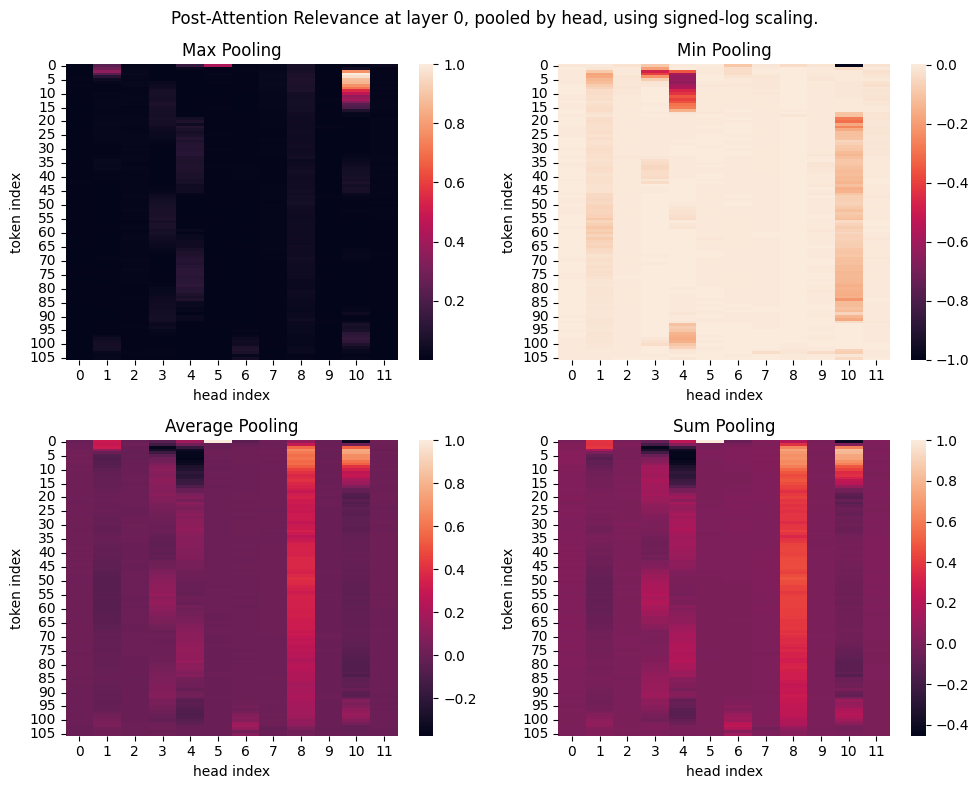

In [33]:
visualize_attention_layer_relevance(checkpoint_vals, layer_ind=0)

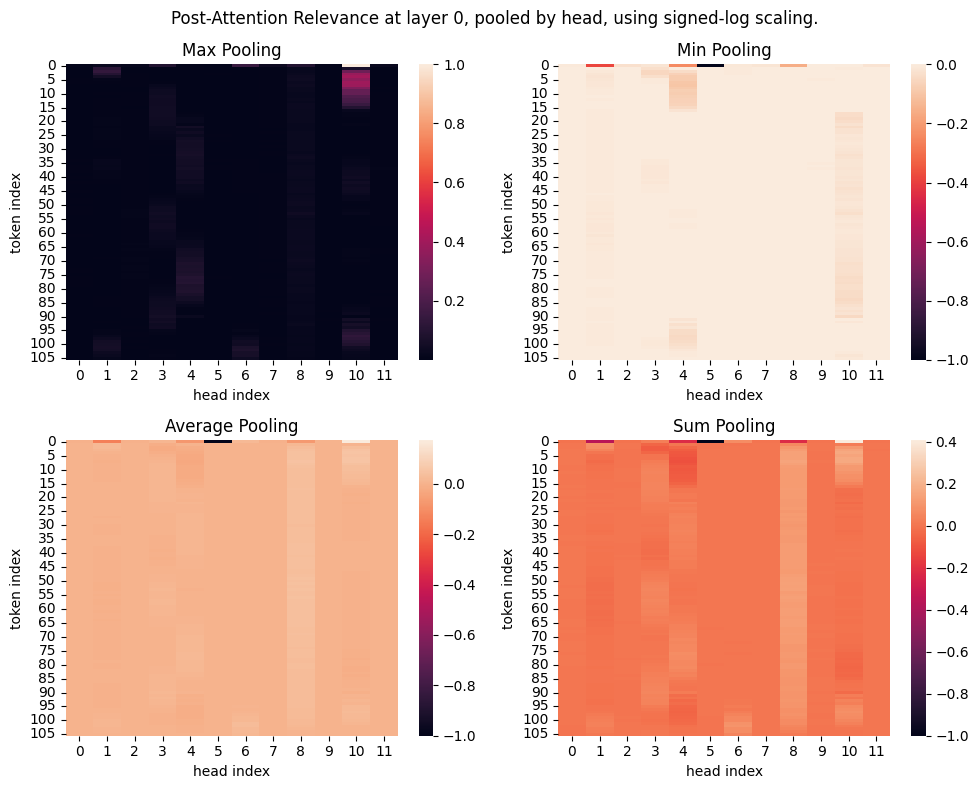

In [34]:
visualize_attention_layer_relevance(checkpoint_vals1, layer_ind=0)

In [22]:
checkpoint_vals.topk(k=50, dim=-1)

torch.return_types.topk(
values=tensor([[[8.4271e-02, 4.5439e-02, 1.5101e-02,  ..., 4.3857e-04,
          4.2968e-04, 4.2116e-04],
         [9.2377e-02, 8.5755e-02, 6.0437e-02,  ..., 4.0363e-03,
          3.7694e-03, 3.6486e-03],
         [2.3919e-02, 2.1323e-02, 1.9772e-02,  ..., 2.1632e-03,
          2.1336e-03, 2.0252e-03],
         ...,
         [1.5348e-02, 1.2537e-02, 8.3134e-03,  ..., 3.9686e-04,
          3.9205e-04, 3.8641e-04],
         [4.8311e-03, 4.4058e-03, 4.3573e-03,  ..., 3.3467e-04,
          3.3110e-04, 3.2160e-04],
         [2.9328e-04, 1.9401e-04, 1.7735e-04,  ..., 7.8616e-06,
          7.5352e-06, 7.3934e-06]],

        [[8.2848e-03, 7.0501e-03, 6.7761e-03,  ..., 1.8518e-03,
          1.8508e-03, 1.8423e-03],
         [1.0666e-02, 9.7755e-03, 6.2319e-03,  ..., 1.4437e-03,
          1.4316e-03, 1.3774e-03],
         [7.3170e-03, 6.5965e-03, 6.3337e-03,  ..., 1.5849e-03,
          1.5516e-03, 1.5364e-03],
         ...,
         [3.3203e-03, 2.9391e-03, 2.9205e-03,  

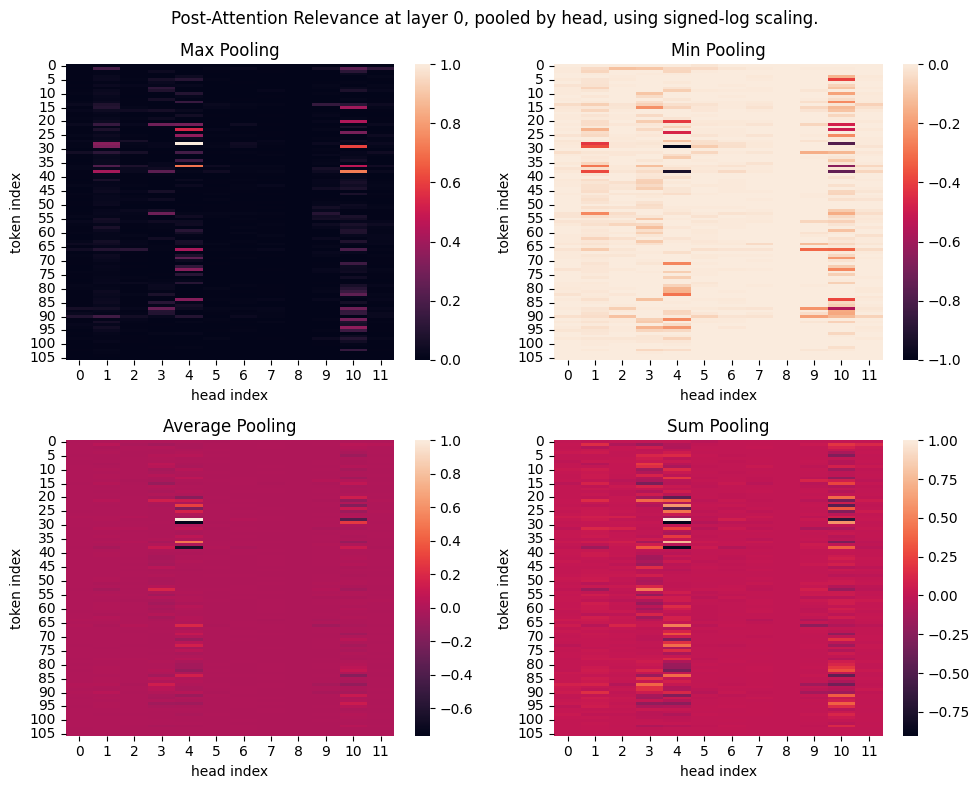

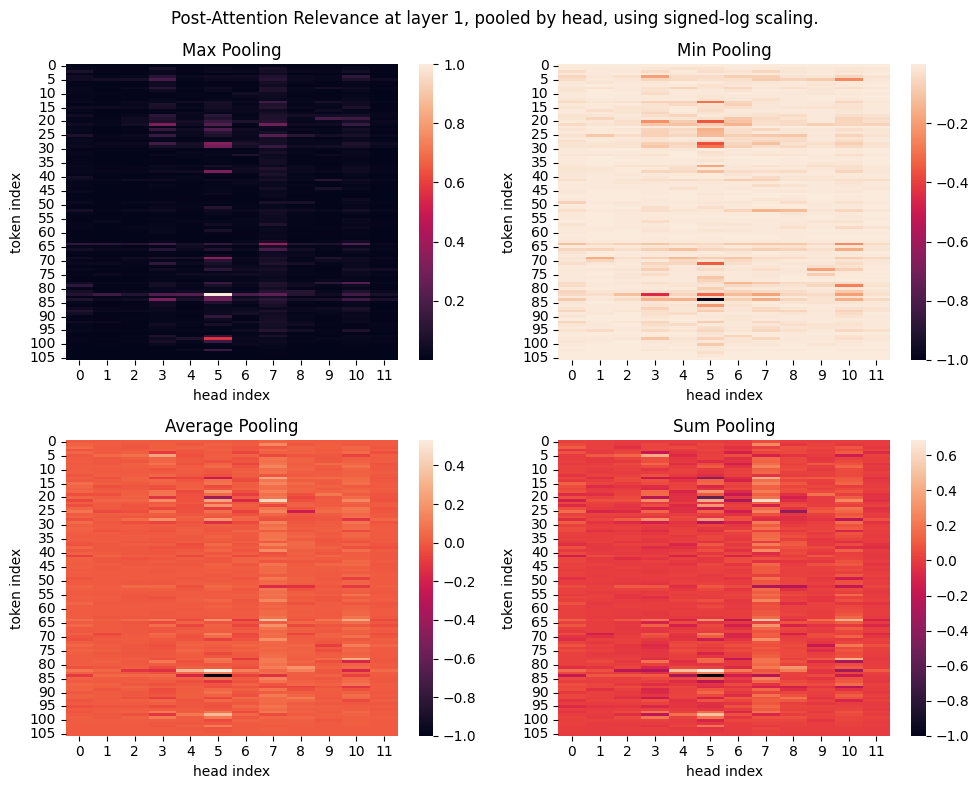

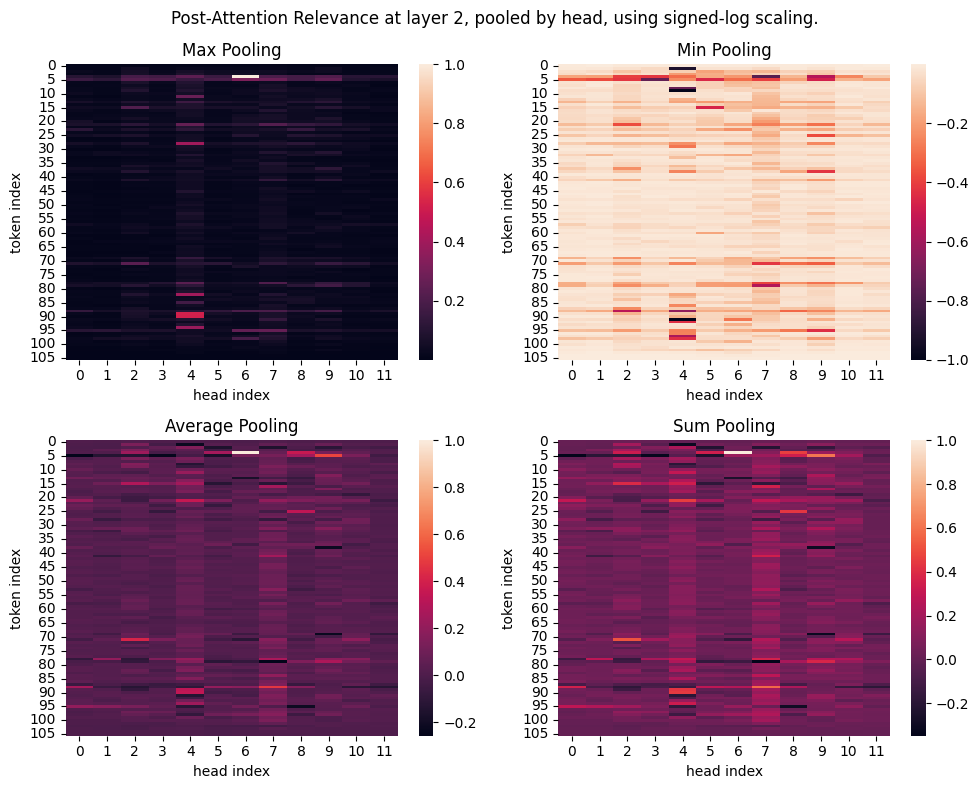

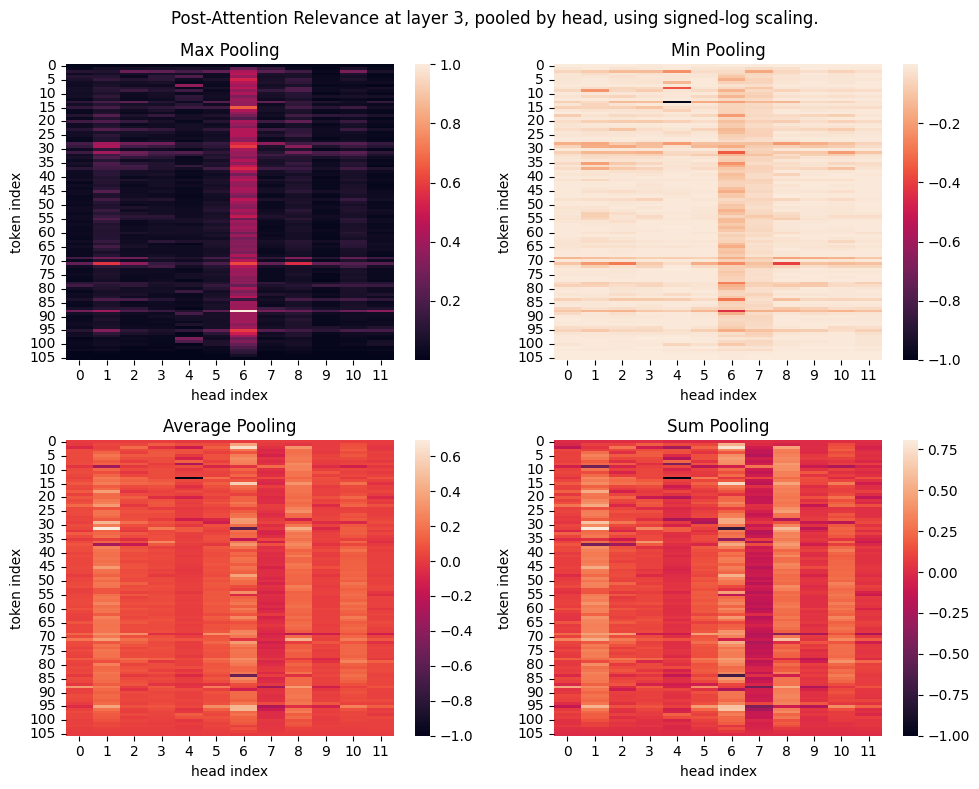

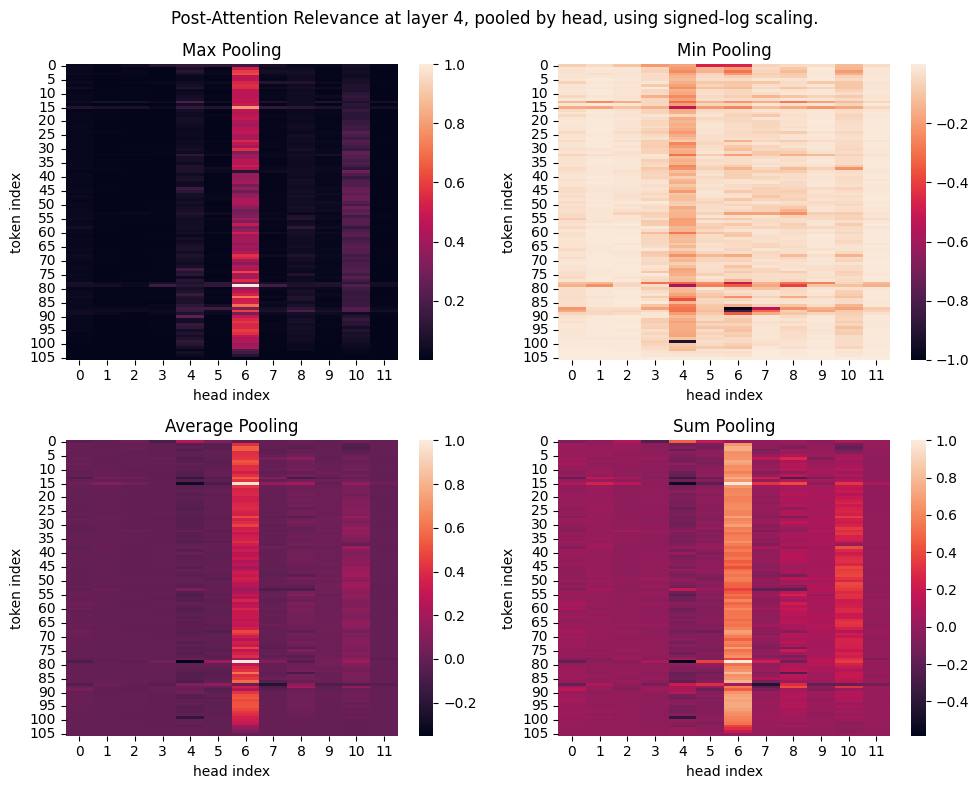

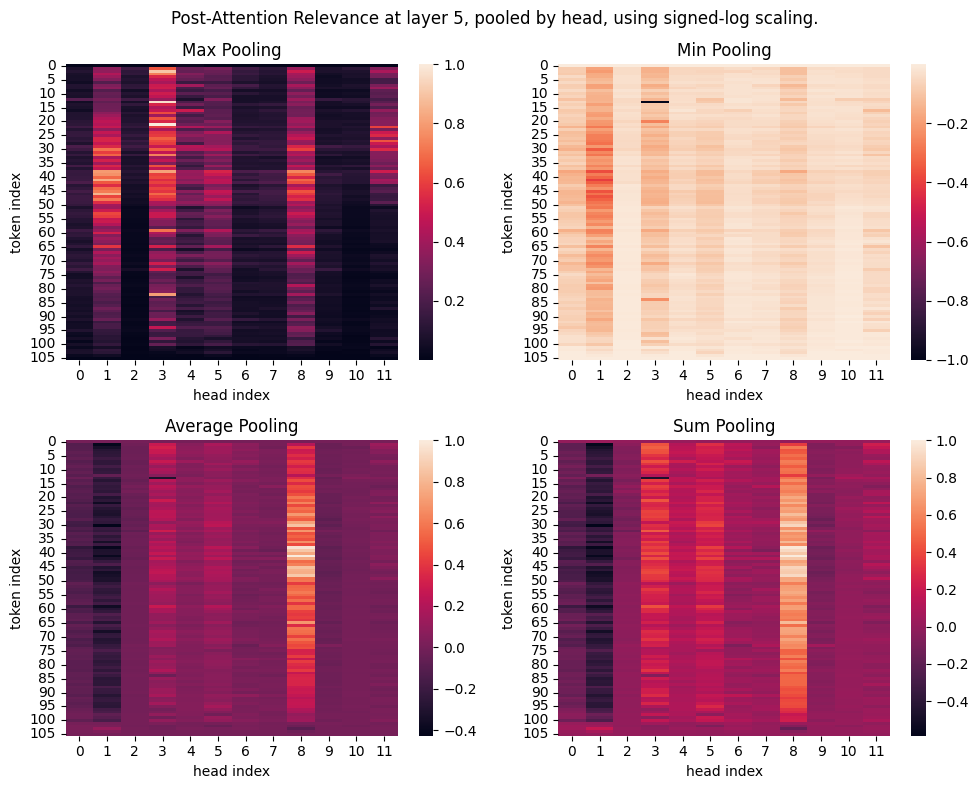

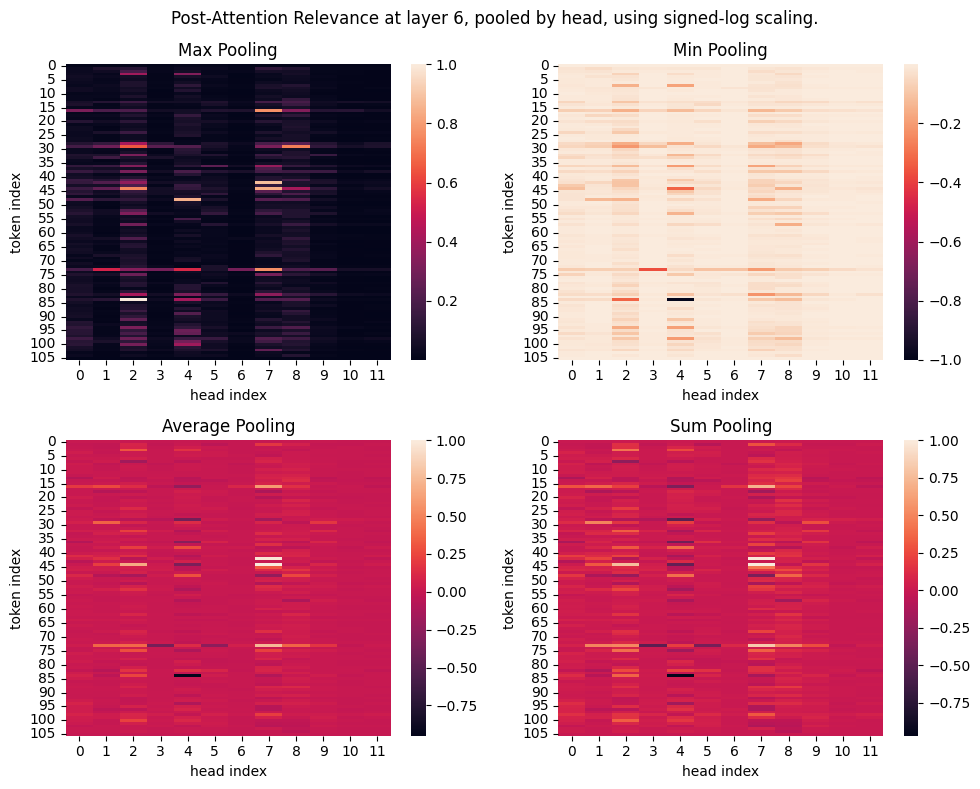

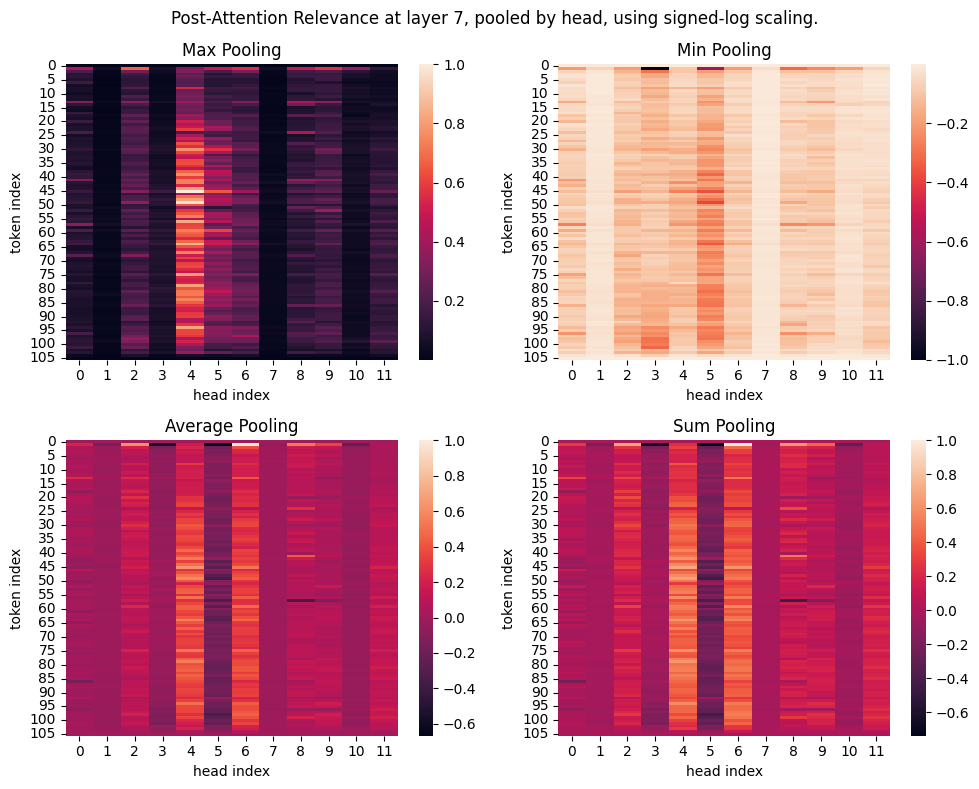

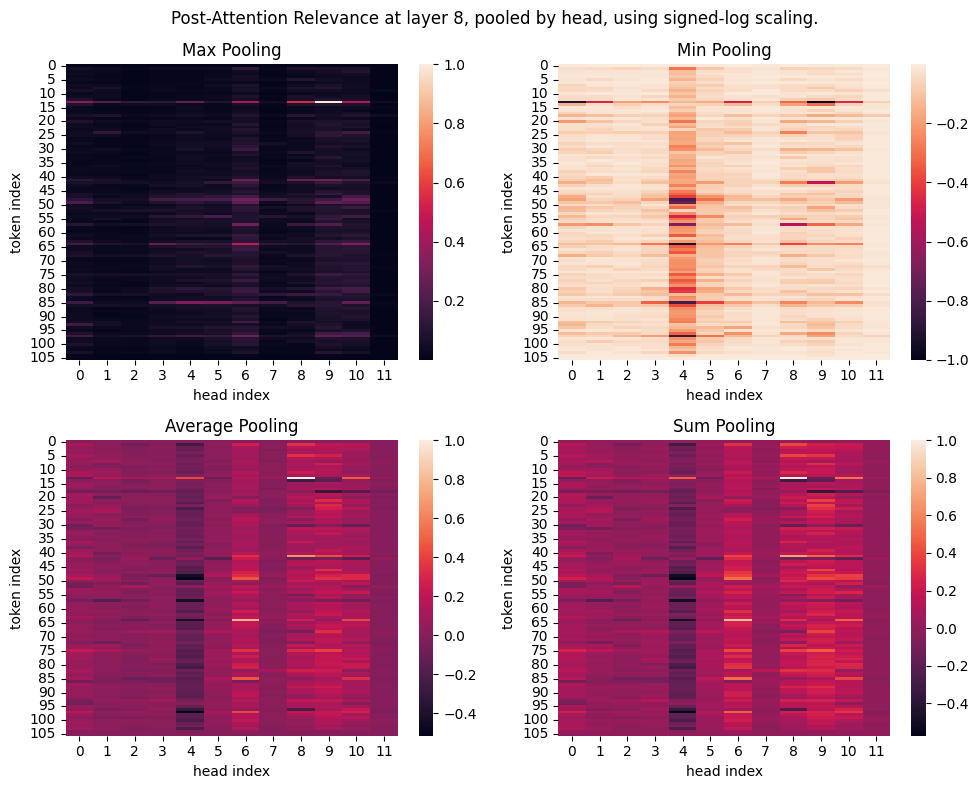

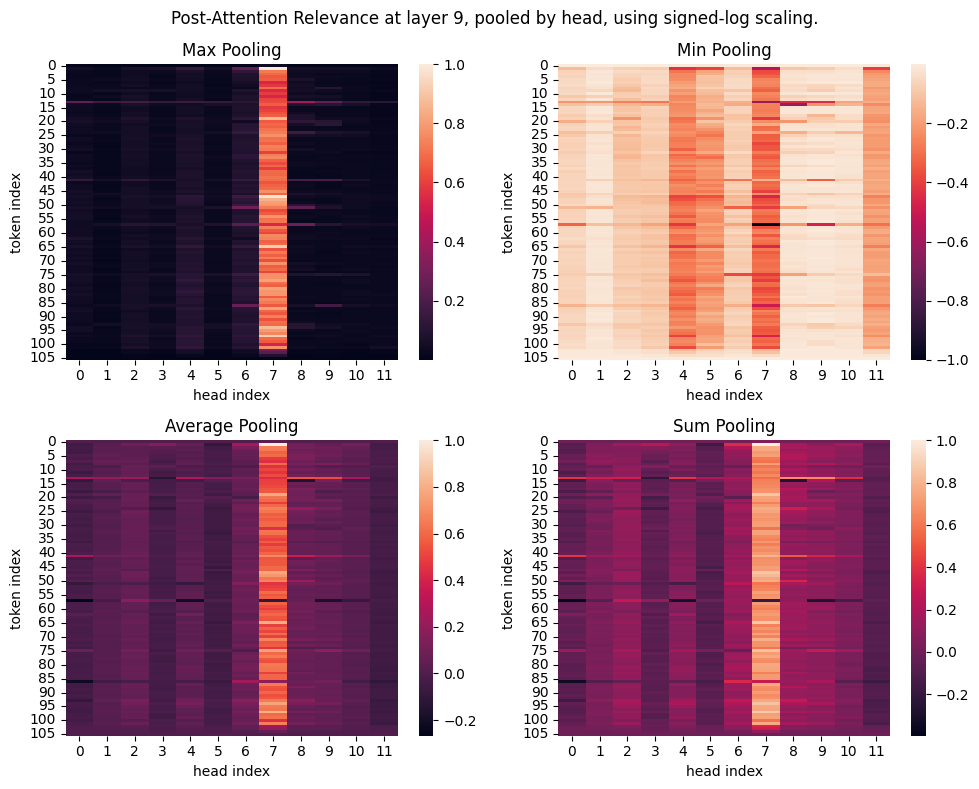

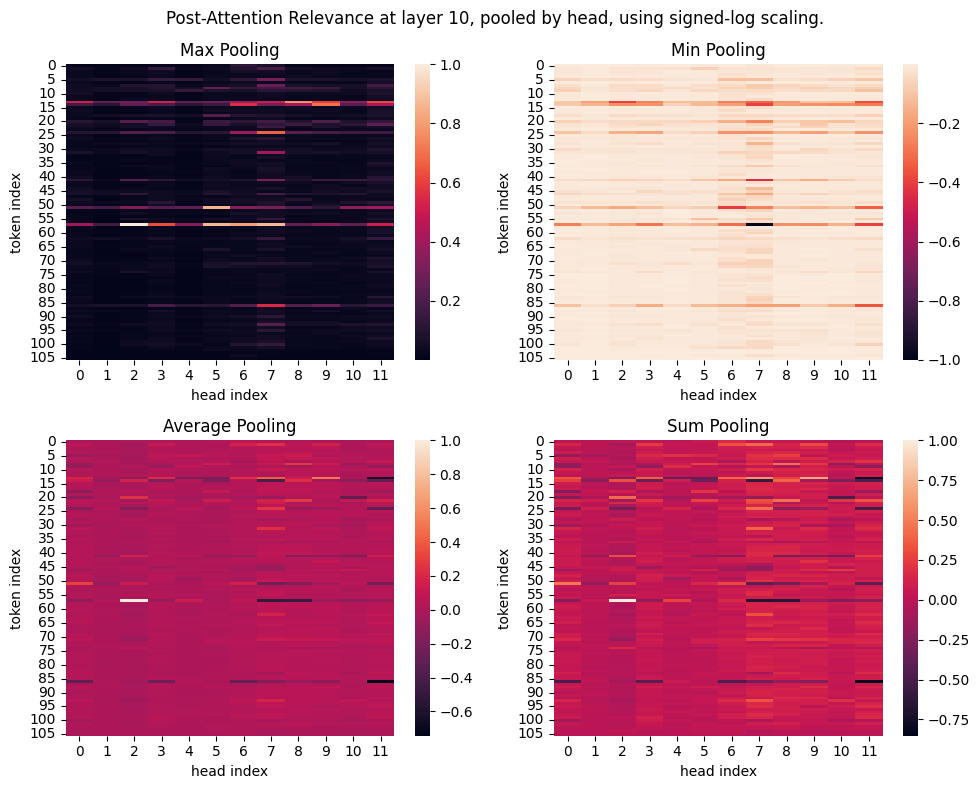

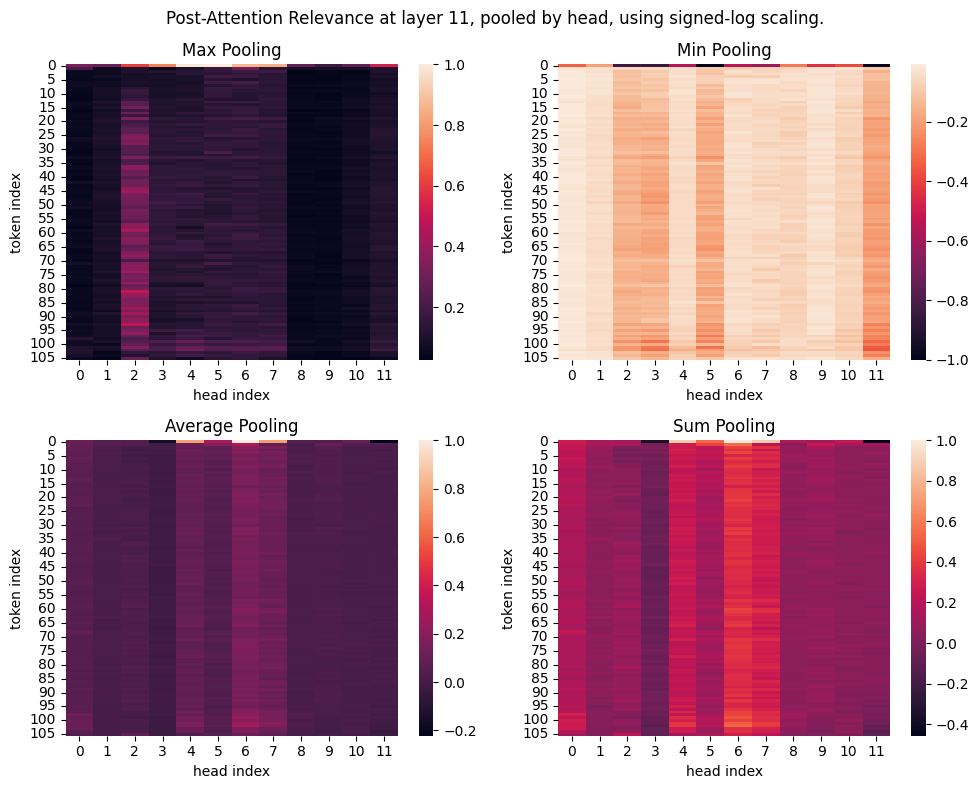

In [17]:
# From the (0,8) disabled model
for i in range(12):
    visualize_attention_layer_relevance(checkpoint_vals, layer_ind=i)

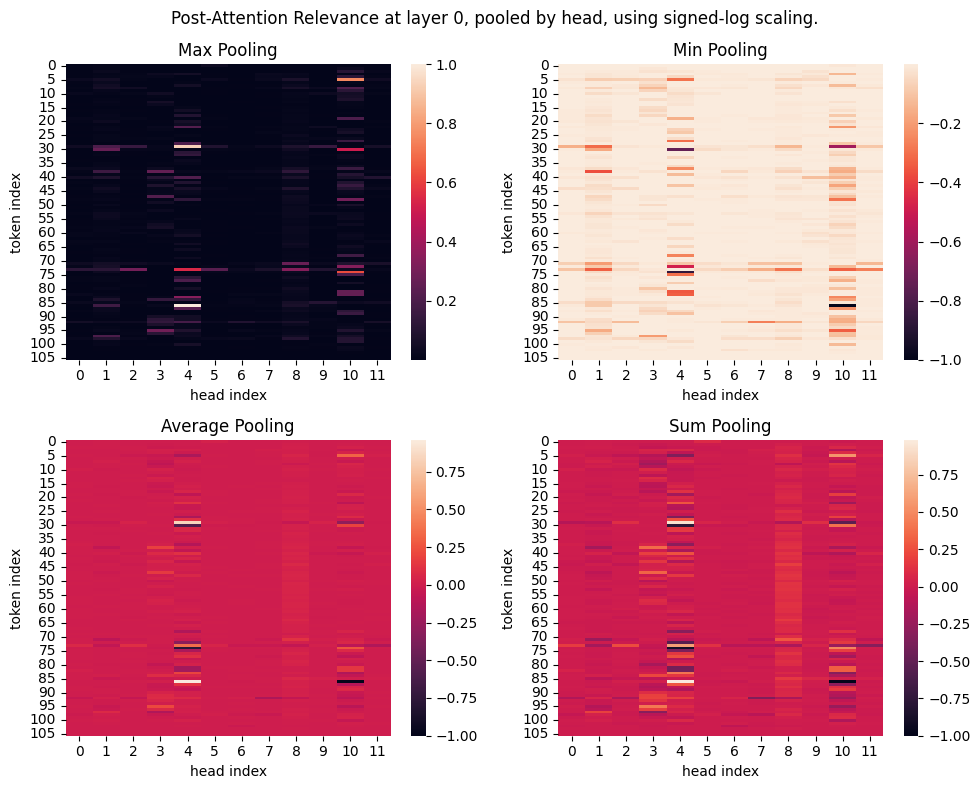

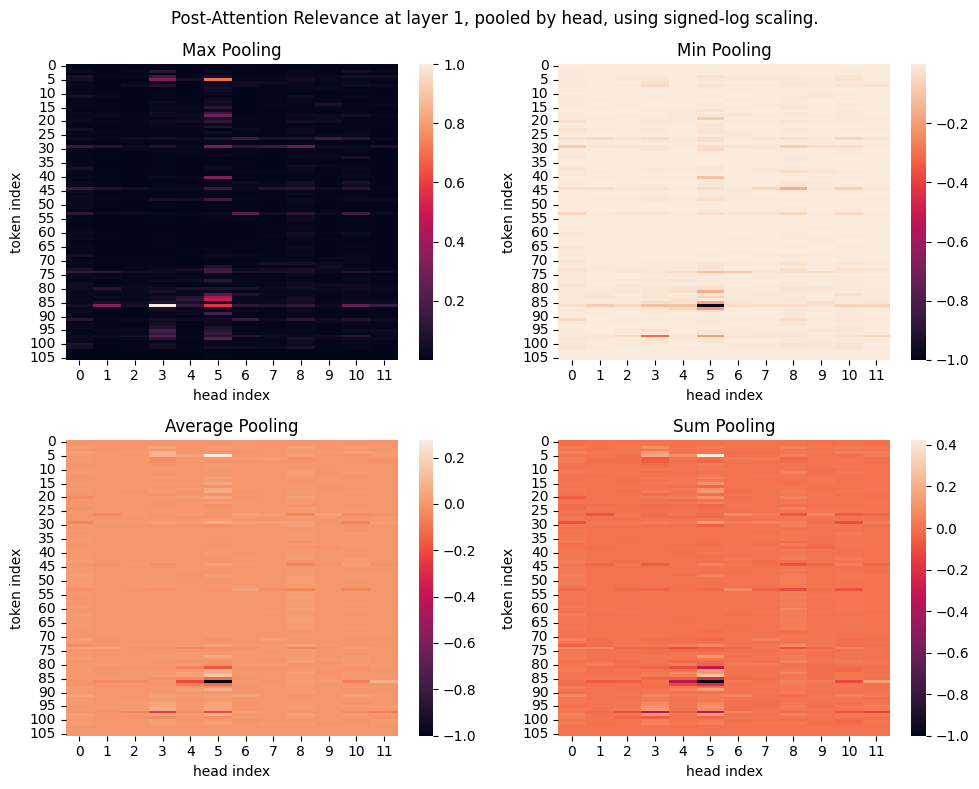

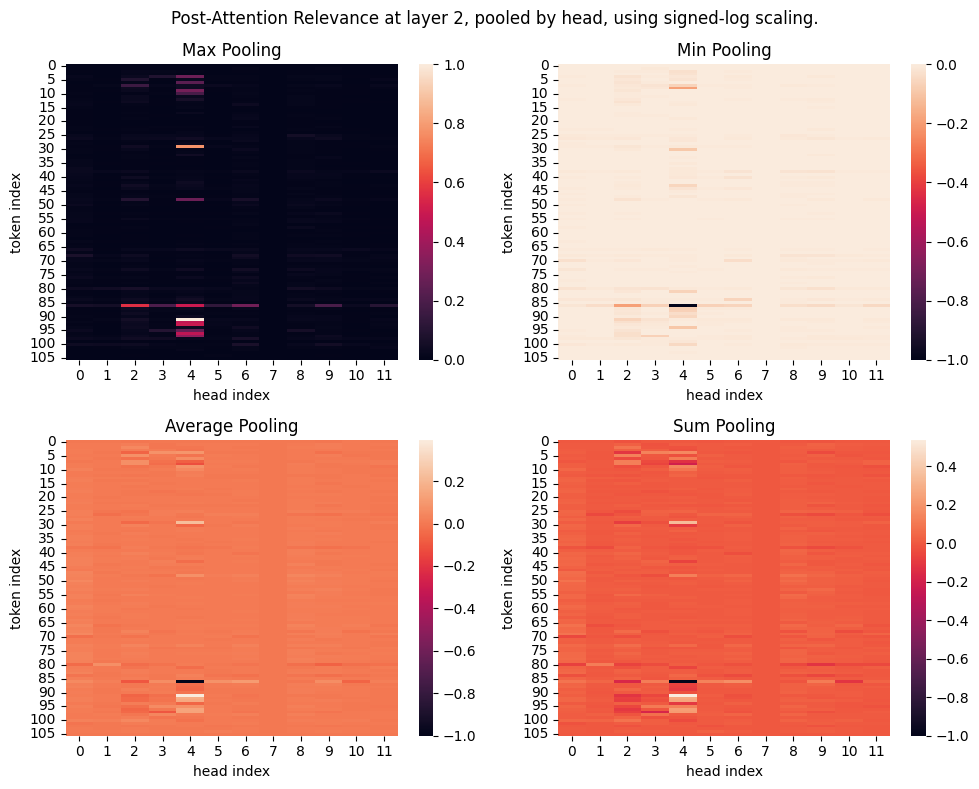

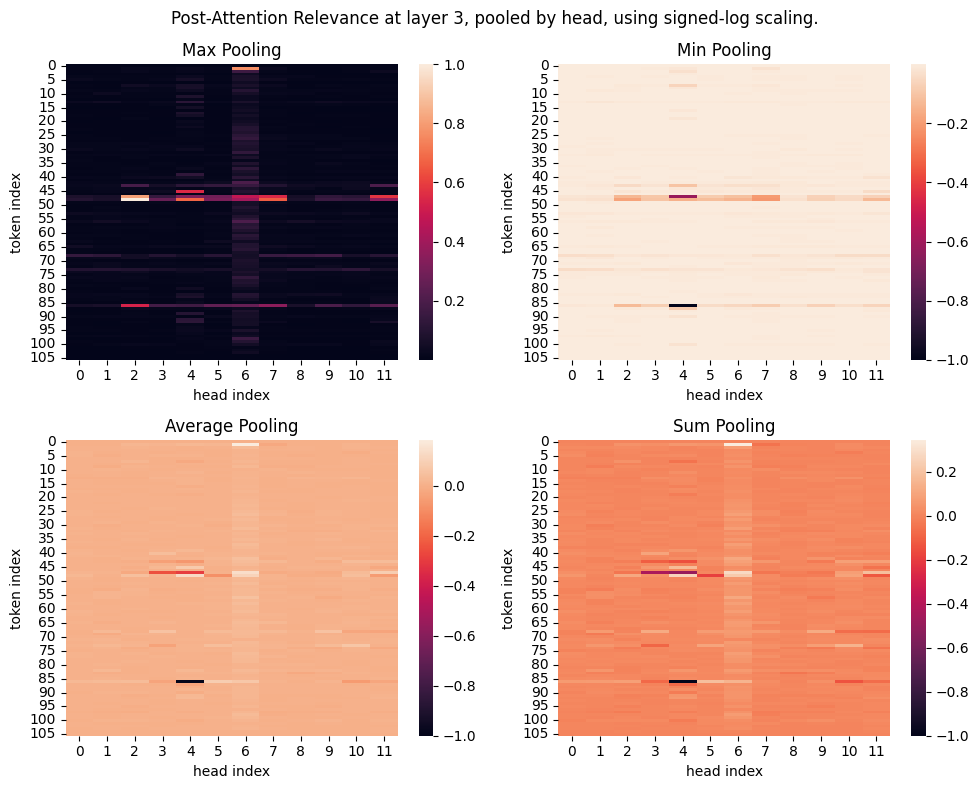

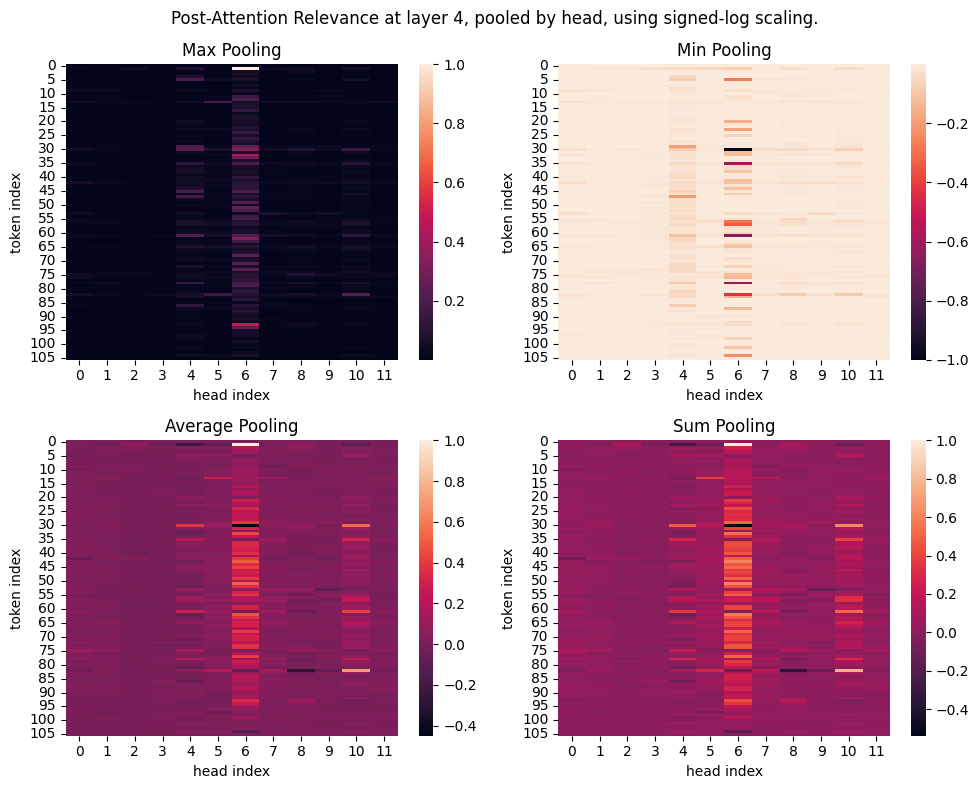

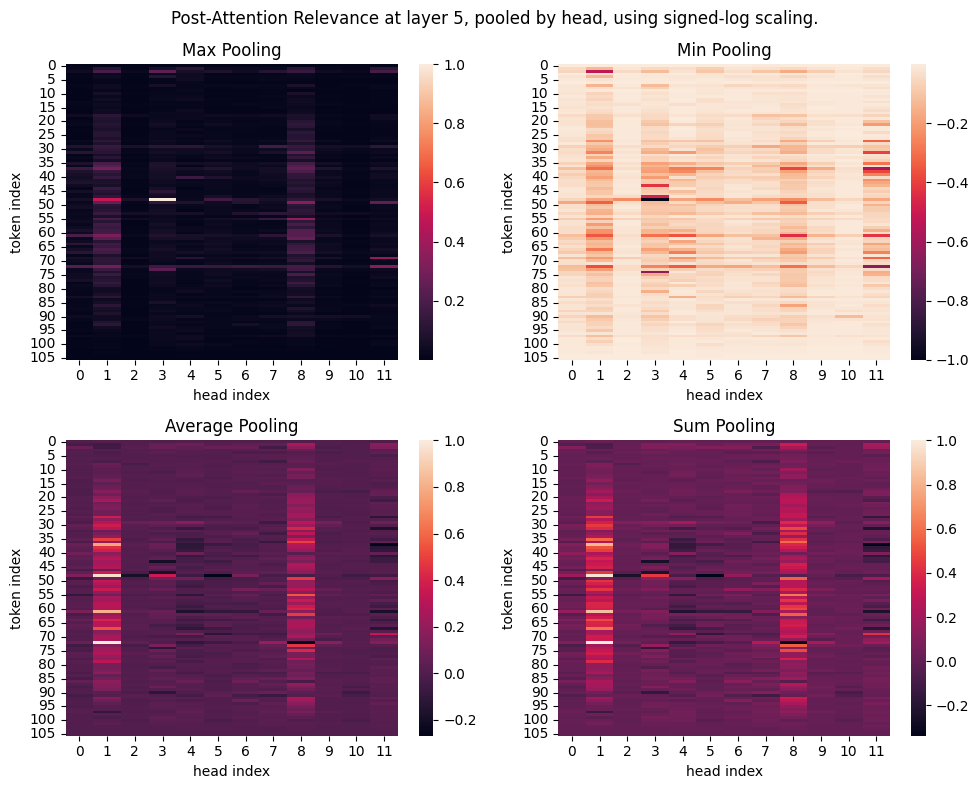

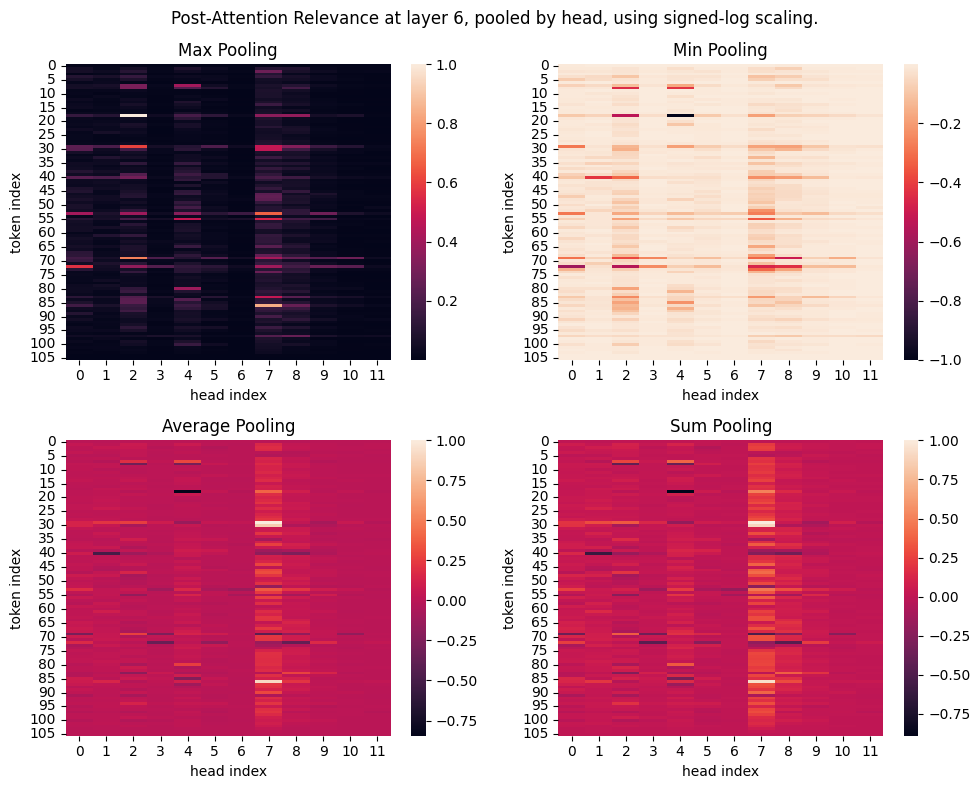

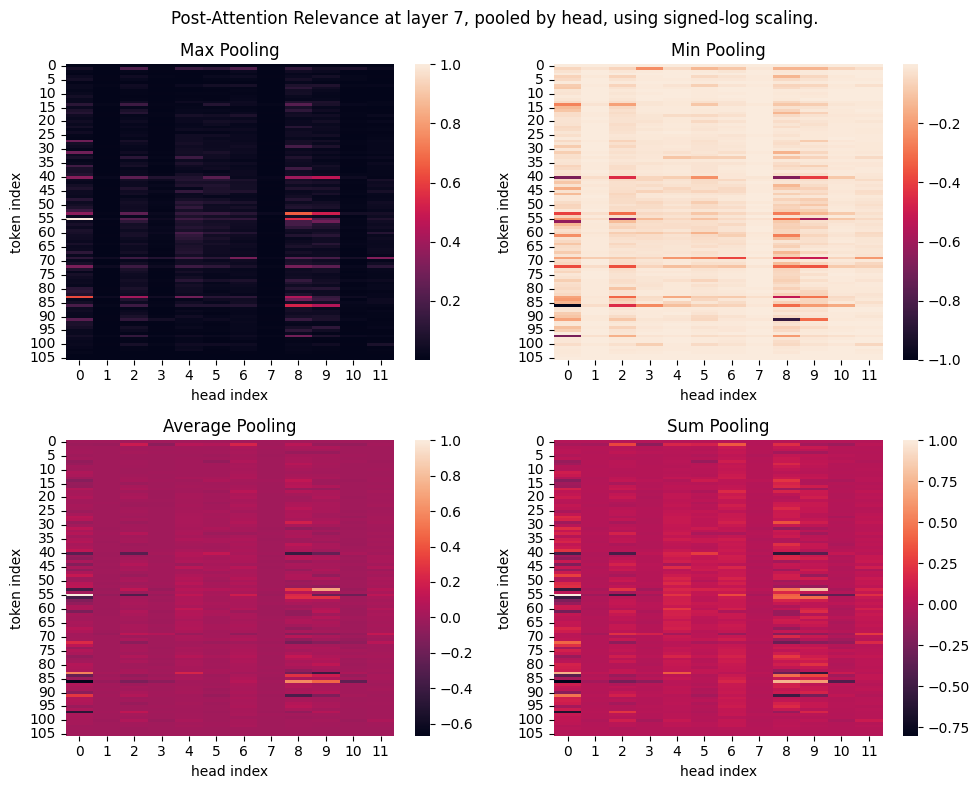

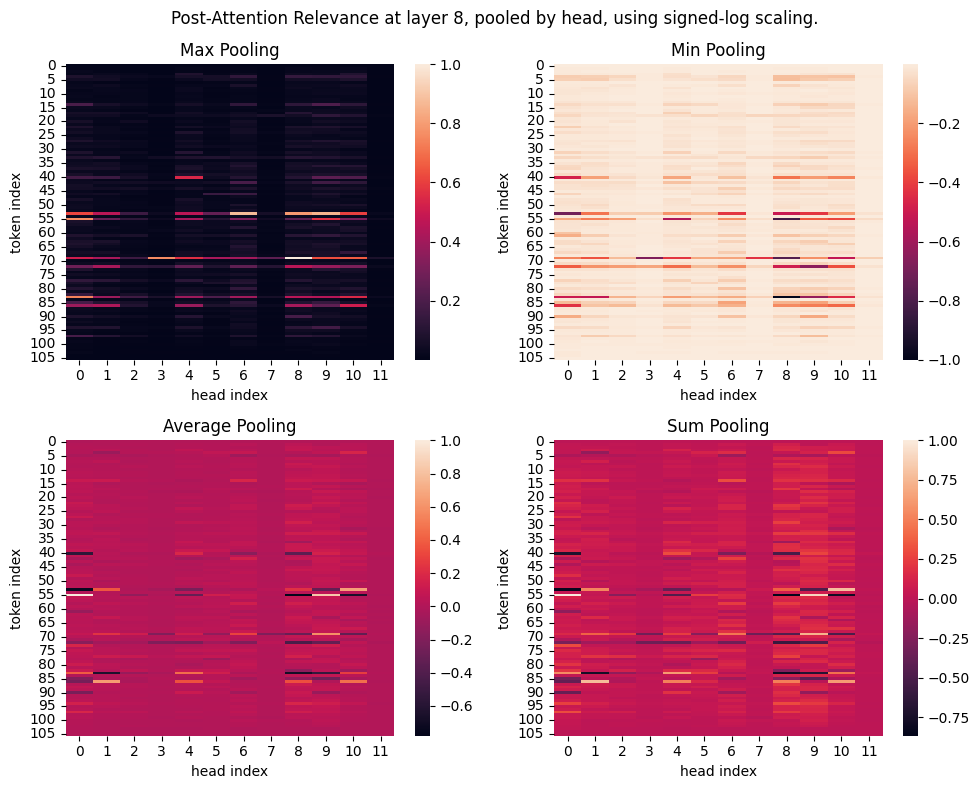

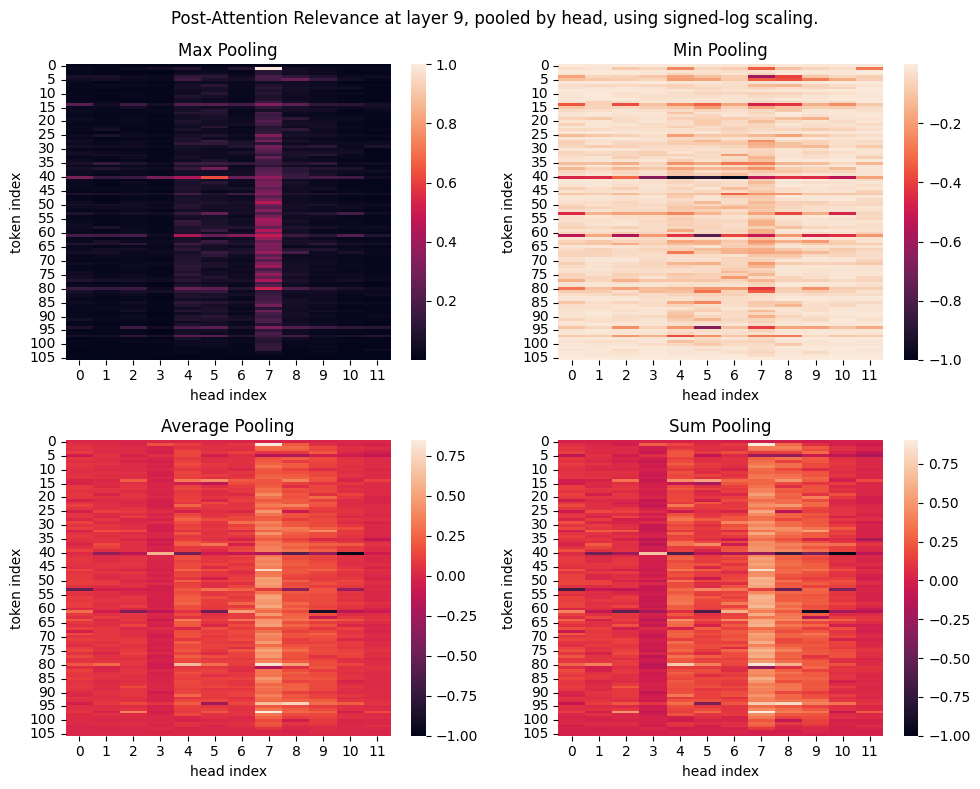

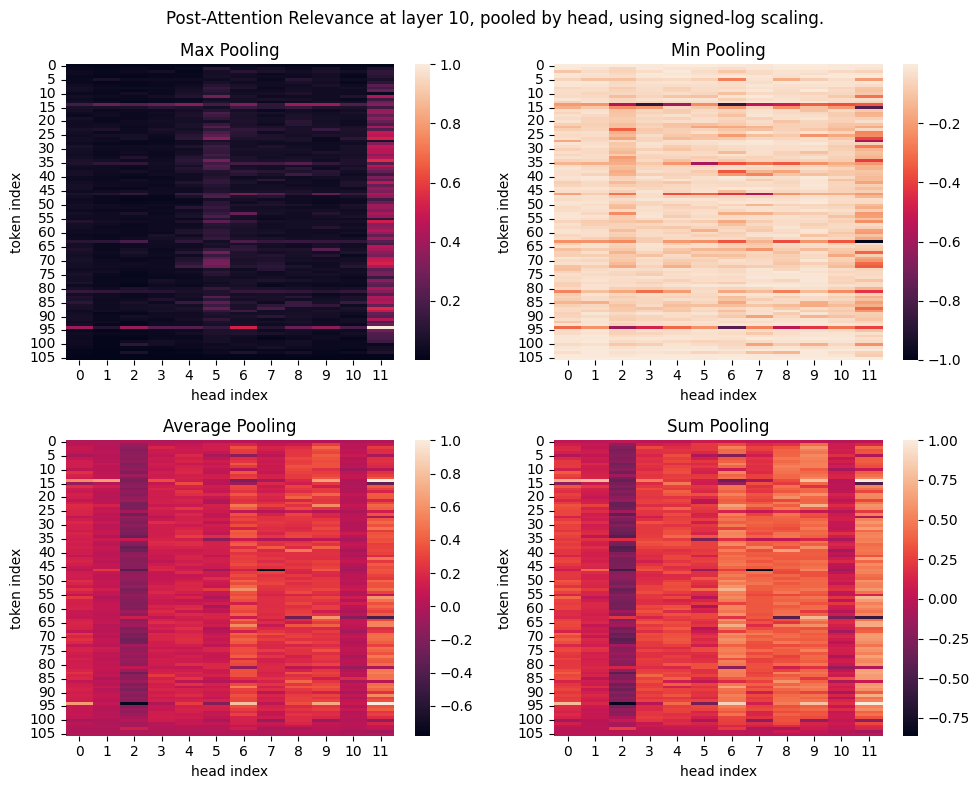

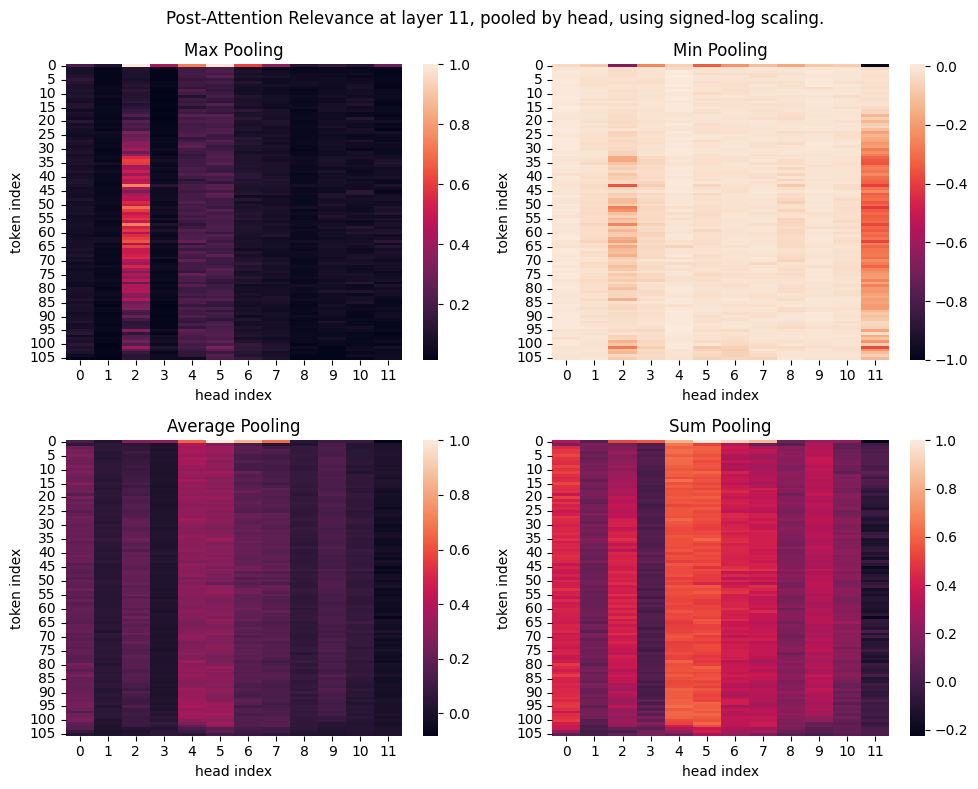

In [17]:
# From the (2,7) disabled model
for i in range(12):
    visualize_attention_layer_relevance(agg_checkpoint_vals, layer_ind=i)

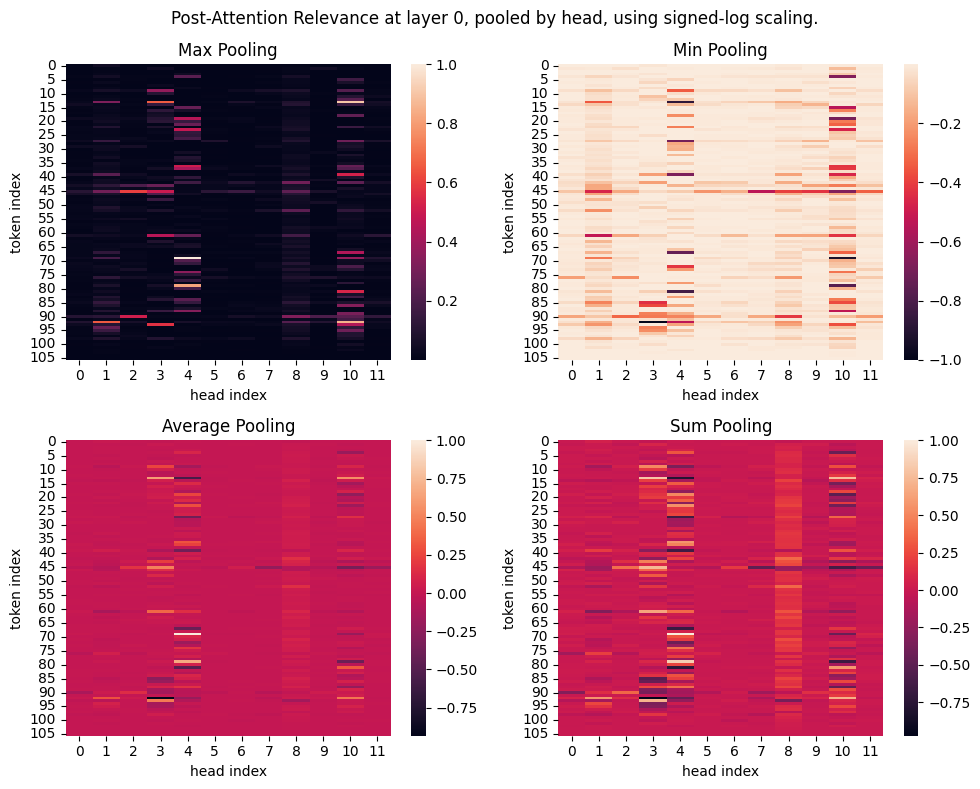

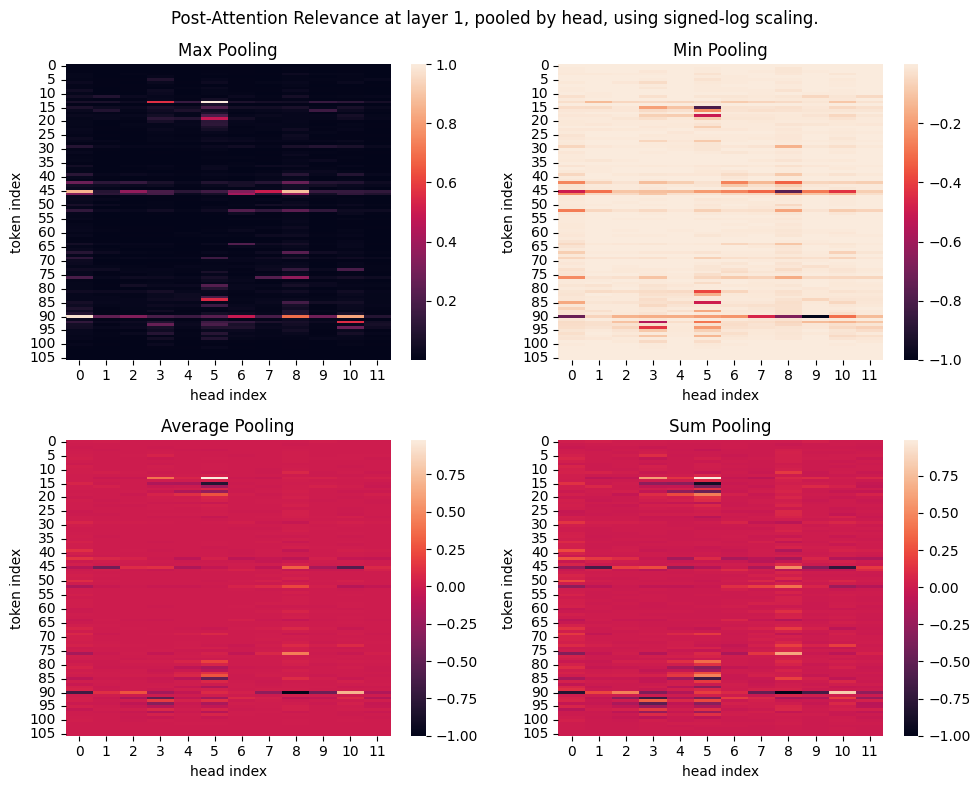

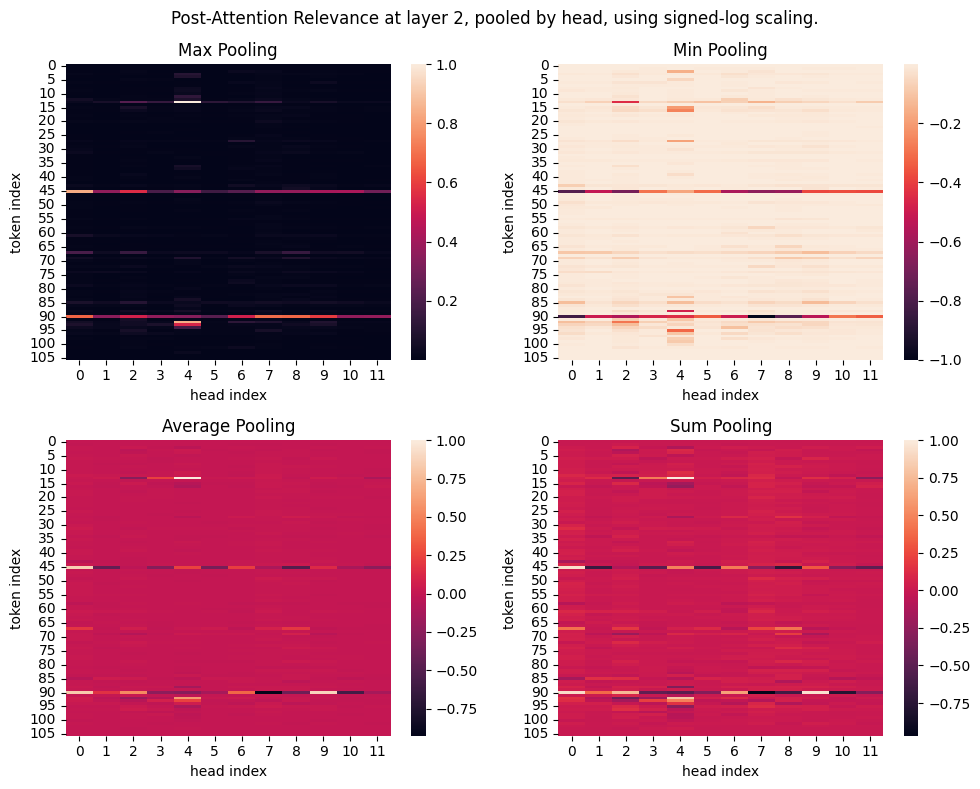

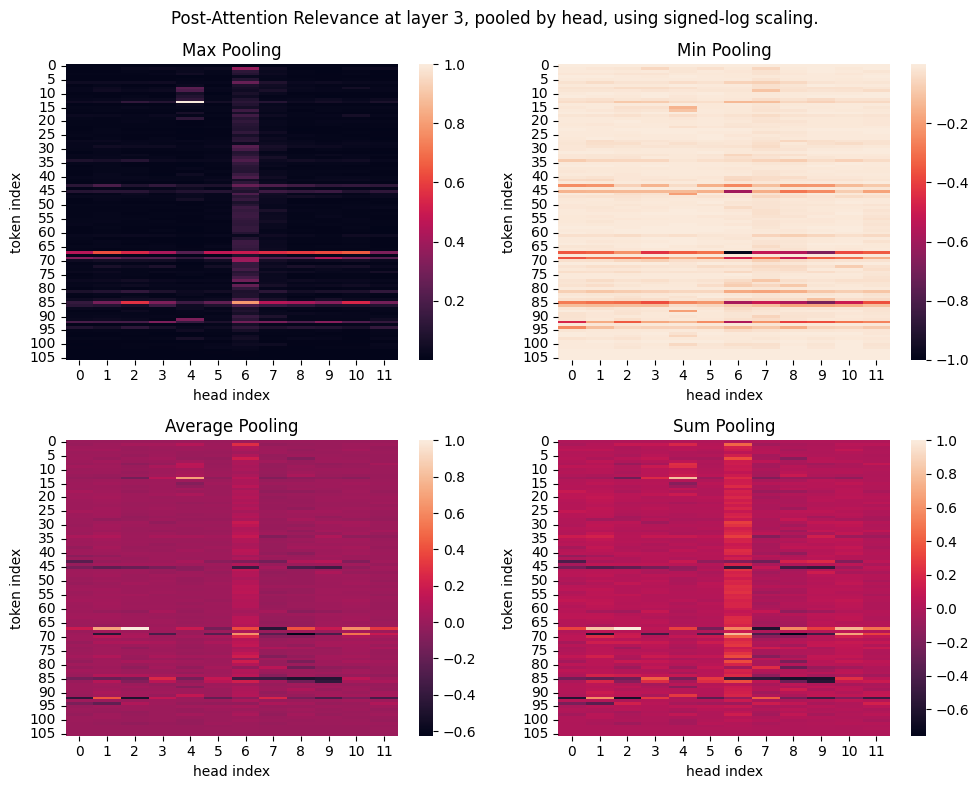

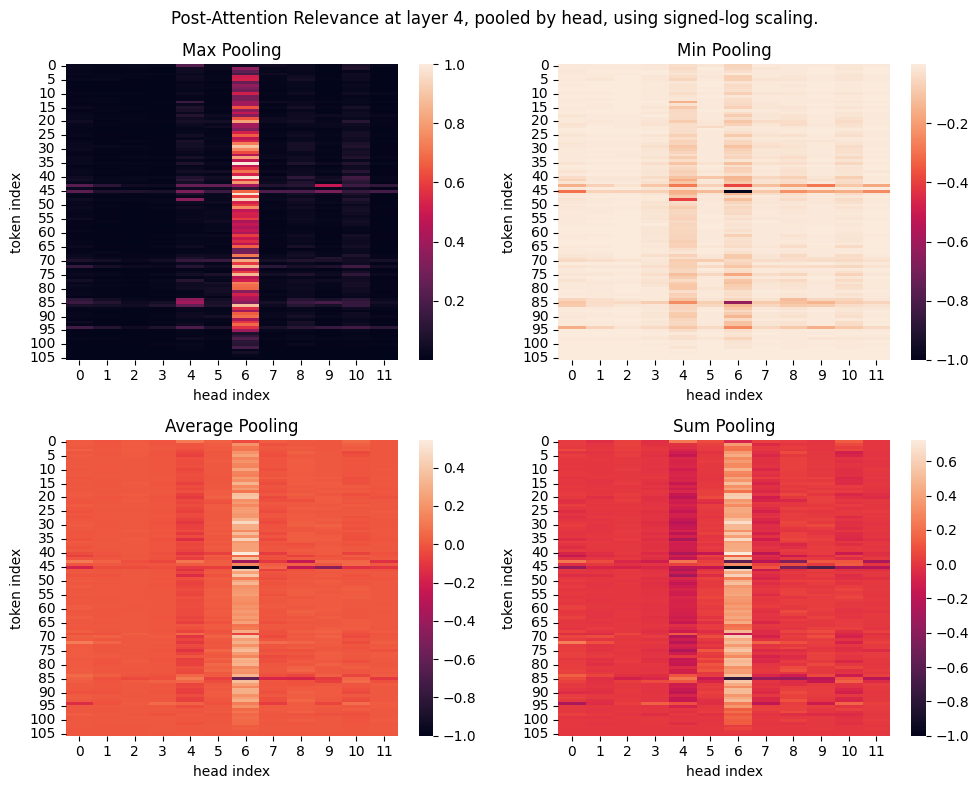

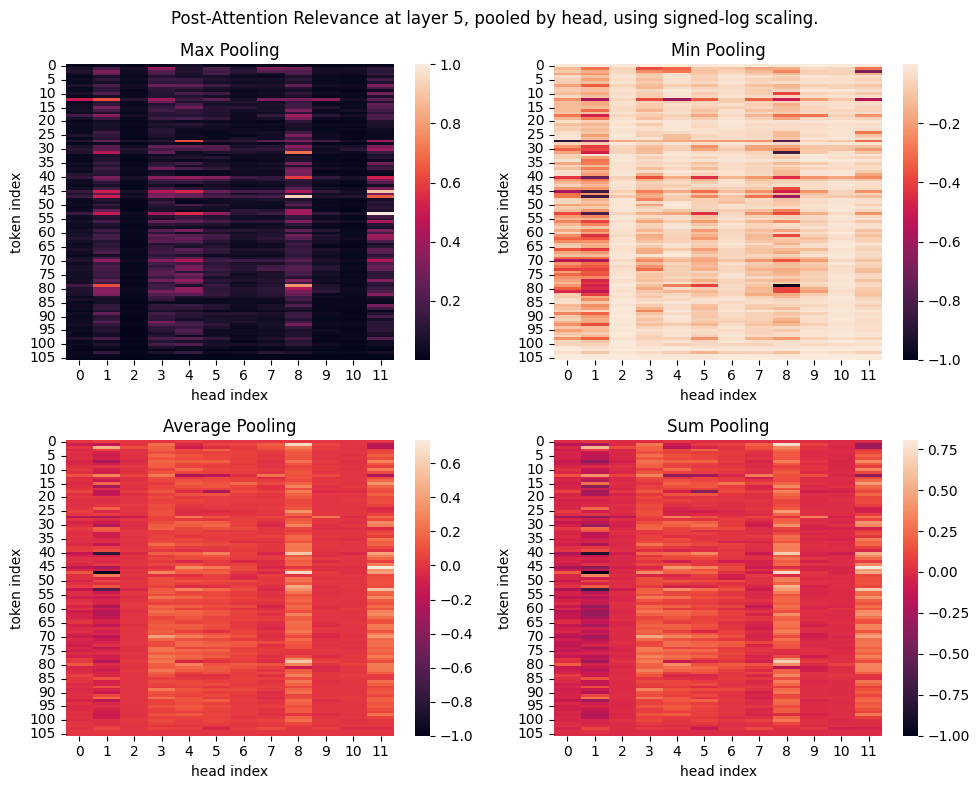

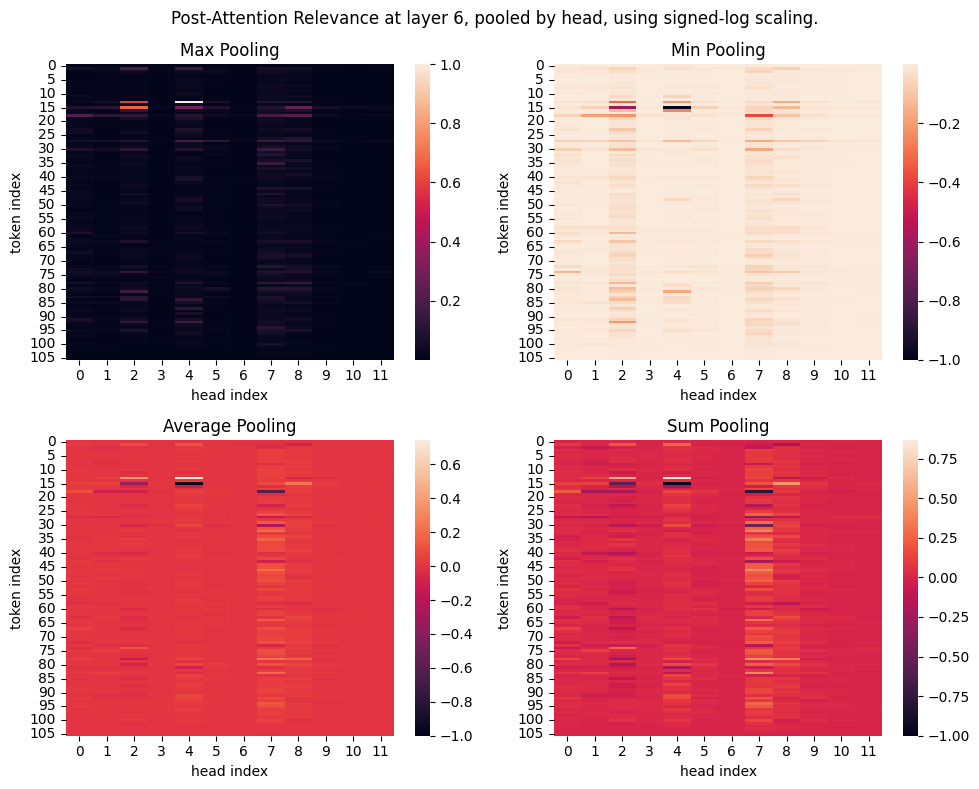

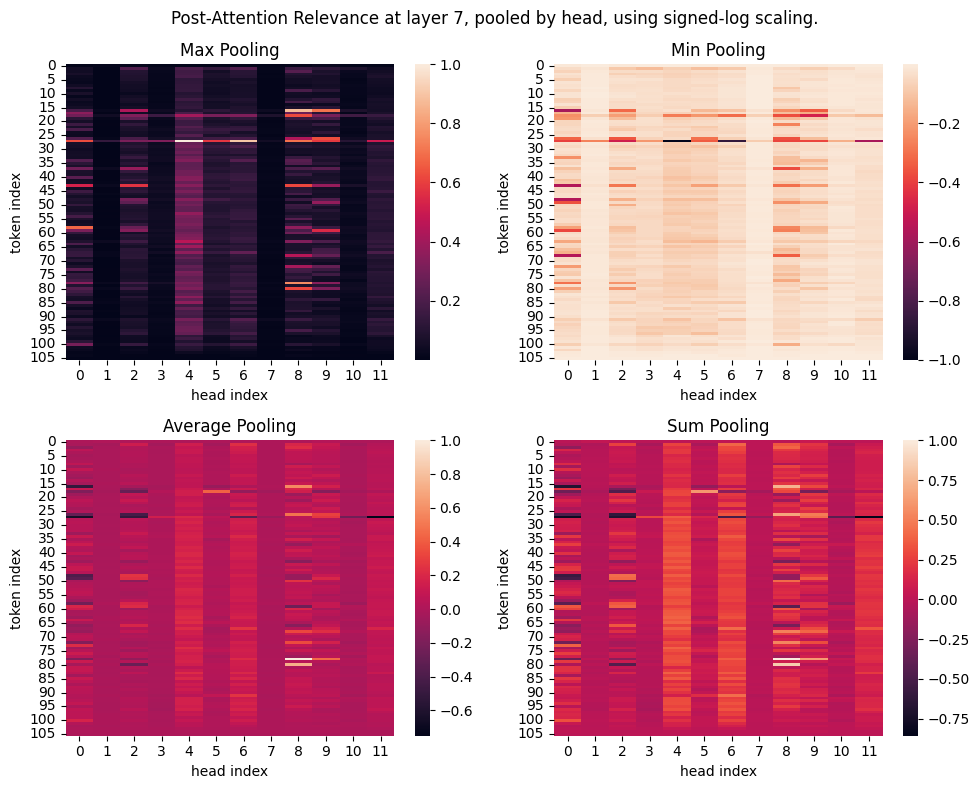

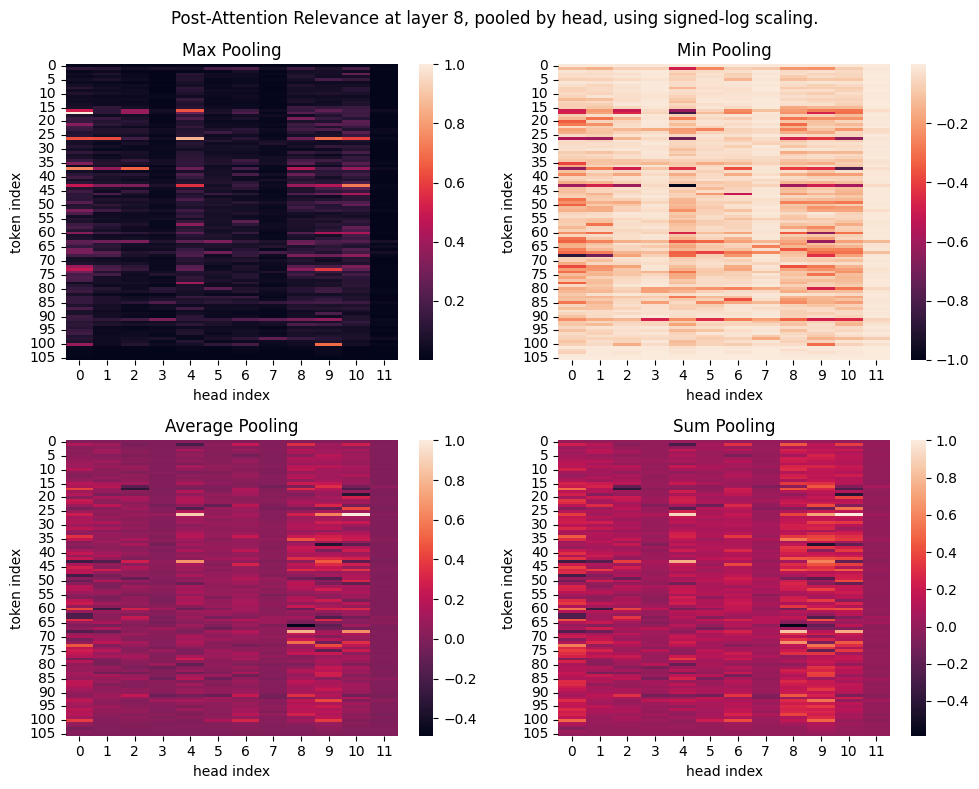

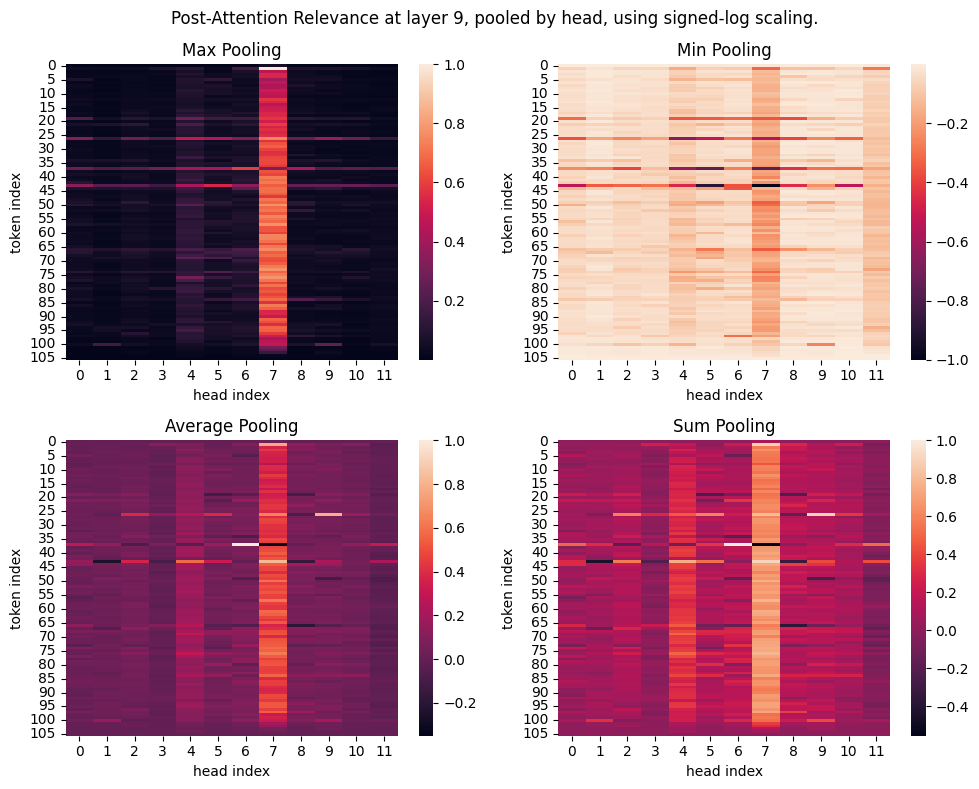

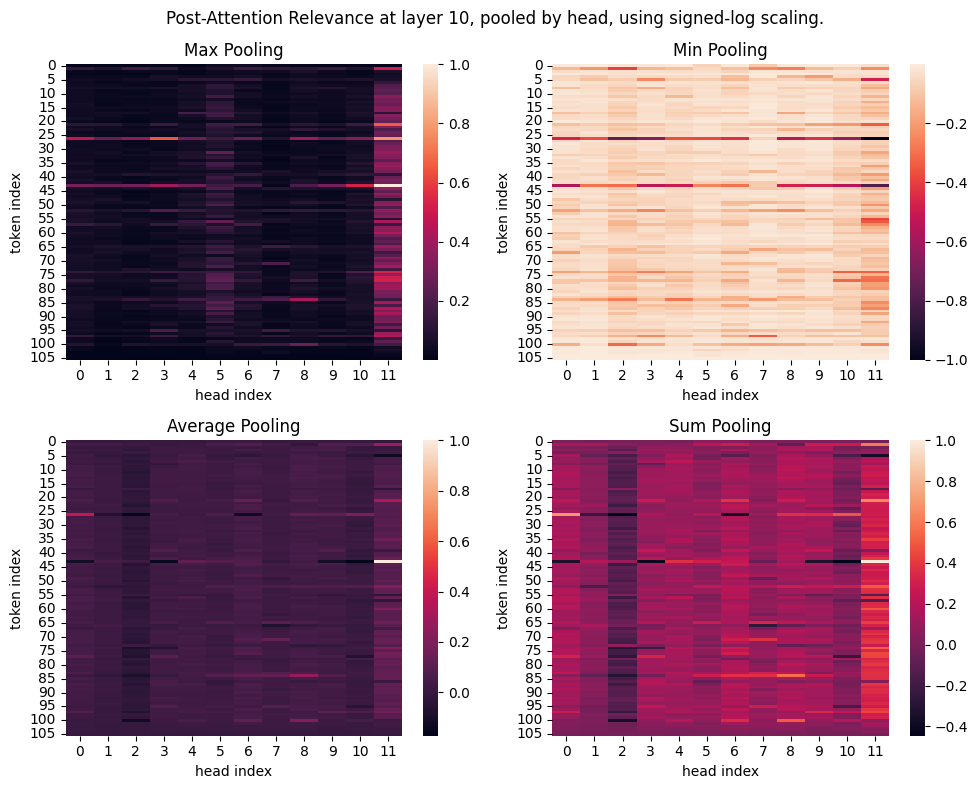

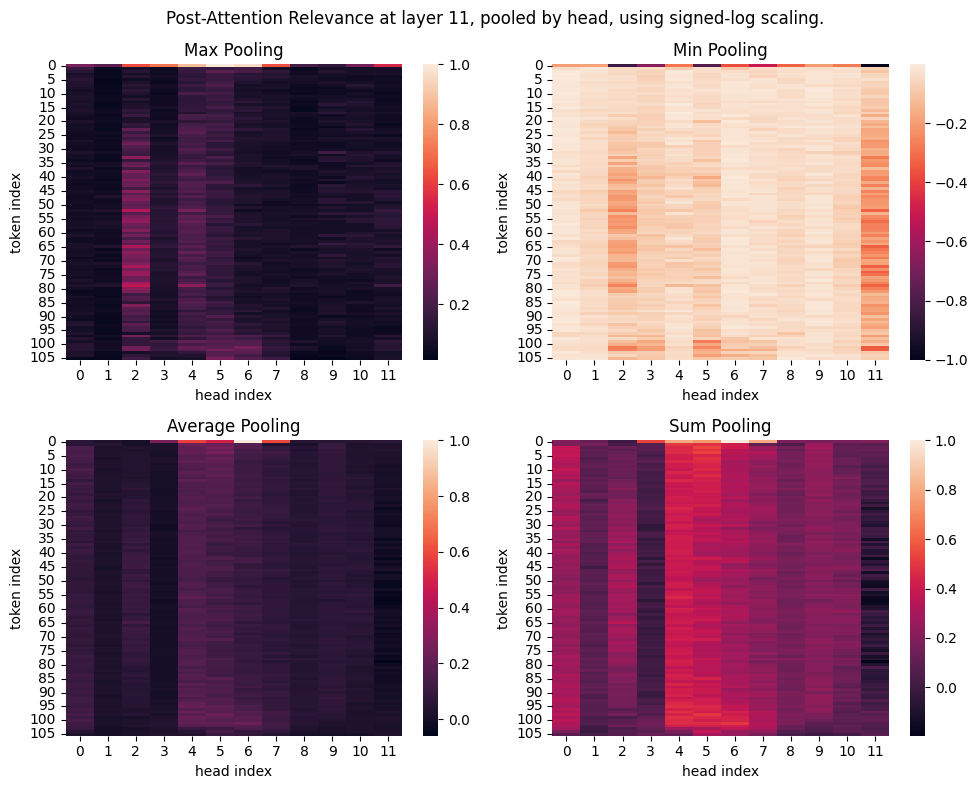

In [17]:
# Normal model
for i in range(12):
    visualize_attention_layer_relevance(checkpoint_vals, layer_ind=i)

In [18]:
peak = torch.cuda.max_memory_allocated()
print("Peak memory (bytes):", peak)

Peak memory (bytes): 1718017024
